<center> École Polytechnique de Montréal <br> Département Génie Informatique et Génie Logiciel <br>  INF8460 – Traitement automatique de la langue naturelle <br> </center>
<center> TP3 INF8460 <br>  Automne 2021 </center>

In [87]:
# PATH = "drive/MyDrive/TPS/TP3"
PATH = "drive/MyDrive/POLY/INF8460/TPS/TP3"
# PATH = "drive/MyDrive/POLY/Traitement Auto de la Langue Naturelle/TPS/TP3"


In [88]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir(PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: ignored

# Importations des différentes librairies

In [89]:
from nltk.tag.util import untag
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
import re
from nltk import word_tokenize

import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
import re
from nltk import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input,Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from tensorflow.keras.optimizers import Adam, SGD,RMSprop,Adagrad,Adadelta
from keras.models import load_model
#from tensorflow.keras.models import create_model


from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, recall_score
from itertools import chain

import pandas as pd

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer


from sklearn.model_selection import RandomizedSearchCV,cross_val_score
from sklearn.metrics import f1_score

import tensorflow as tf

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential, load_model,Model
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input, GRU, Activation, Masking

from keras.layers import Dense, Input, GRU, Embedding, Dropout, Activation, Masking
from keras.layers import BatchNormalization

#defining the checkpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K

from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from tensorflow.keras.optimizers import Adam, SGD

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


In [90]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [91]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

In [92]:
 #download crf library for crf layer usage
 !pip install tf2crf

In [ ]:
from tf2crf import CRF, ModelWithCRFLoss,ModelWithCRFLossDSCLoss

In [93]:
#download sklearn-crfsuite for crf implementation
!pip install sklearn-crfsuite
!pip install -U 'scikit-learn<0.24'

In [94]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn_crfsuite import CRF

## Importation de Glove

In [ ]:
import requests, zipfile, io
zip_file_url = "http://nlp.stanford.edu/data/glove.840B.300d.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
import codecs
print('loading word embeddings...')


embeddings_index = {}
f = codecs.open('glove.840B.300d.txt', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

# Fonctions utiles 

In [ ]:
def show_distrib(all_tokens):
  max_len, mean_len = 0, 0
  tok_count = {}
  nb_tags = 0
  for tags in all_tokens:
    nb_tags += len(tags)
    for tag in tags:
      if tok_count.get(tag) is None:
        tok_count[tag] = 1
      else:
        tok_count[tag] += 1
  tok_freq = {tag: value / nb_tags for (tag, value) in tok_count.items()}
  plt.bar(tok_freq.keys(), tok_freq.values())
  plt.title('Distribution des tag')
  plt.xlabel('Tags')
  plt.ylabel('Fréquence')
  plt.show()

In [ ]:
# we get data in the form of a list of tokens and tags given the their dataframe

def vectorize_tagged_sentence(df, folder):
  sentences = []
  ids = []
  tags = []
  for doc_id in tqdm(doc_ids[folder]):
    doc = df[df["DocID"] == doc_id]
    sentences.append(doc["Token"].values.astype(str))
    tags.append(doc["Tag"].values)
    ids.append(doc["TokenID"].values.astype(str))
  return sentences,tags, ids

def vectorize_test_sentence(df):
  sentences = []
  ids = []
  for doc_id in tqdm(doc_ids['test']):
    doc = df[df["DocID"] == doc_id]
    sentences.append(doc["Token"].values)
    ids.append(doc["TokenID"].values.astype(str))
  return sentences, ids


In [ ]:
def check_training_preproccessing():
  """Cette fonction sert à vérifier que les données d'entrainements possèdent les propriétés attendues.
  Notemment on vérifie la proportion de chaque tag ce qui permet d'avoir un estimation de si on en a oulié.
  Ensuite on applique """
  max_len, mean_len = 0, 0
  tok_count = {}
  for sentence in train_sentences:
    max_len = max(max_len, len(sentence))
    mean_len += len(sentence)
  nb_tags = 0
  for tags in train_tags:
    nb_tags += len(tags)
    for tag in tags:
      if tok_count.get(tag) is None:
        tok_count[tag] = 1
      else:
        tok_count[tag] += 1
  tok_freq = {tag: value / nb_tags for (tag, value) in tok_count.items()}
  print(f"max_len={max_len}, mean_len={mean_len / len(train_sentences):.1f}")
  print(f"tok_freq={tok_freq}")

  bad = 0
  for k, tags in enumerate(train_tags):
    for i in range(len(tags)):
      if "B" in tags[i] and not (i == 0 or 'L' in tags[i-1] or 'U' in tags[i-1] or 'O' in tags[i-1]):
        bad += 1
        # print(tags)
      if "L" in tags[i] and not (i == len(train_tags)-1 or 'B' in tags[i+1] or 'U' in tags[i+1] or 'O' in tags[i+1]):
        bad += 1
        # print(tags)
  print("nb of badly formed taggings:",bad)

  nb_entity = 0
  for doc in os.listdir("data/train"):
    if ".ann" in doc:
      ANN = pd.read_csv(f"data/train/{doc}", delimiter="\t", names=["Type", "Annotation", "Tokens"])
      ANN = ANN.drop(ANN[ANN['Type'].map(lambda x: x[0]) != "T"].index)
      ANN["Tokens begining"] = ANN["Annotation"].apply(lambda x: int(x.split()[1]))
      ANN = ANN.to_numpy()
      ANN = ANN[np.argsort(ANN[:, 3])]
      p = 0
      for i in range(ANN.shape[0]):
        if i > 0 and int(re.split(" |;", ANN[i,1])[1]) <= int(re.split(" |;", ANN[p,1])[2]):
          continue
        p = i
        nb_entity += 1

  nb_found = 0
  for tags in train_tags:
    for tag in tags:
      if "B" in tag or "U" in tag:
        nb_found += 1
  print("Nb of labeled entity:", nb_entity, "\ nb of found entity:", nb_found)
  print(f"Prop of possibly missing tags: {(nb_entity-nb_found)/nb_entity:.4f}%")
# check_training_preproccessing()

In [ ]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [ ]:
def get_seq(array):
  return np.argmax(array, axis=2).flatten()
def get_f1_micro(y_true, y_pred): 
  return f1_score(get_seq(y_true), get_seq(y_pred), average='micro') 
def get_f1_macro(y_true, y_pred):
  return f1_score(get_seq(y_true), get_seq(y_pred), average='macro')

In [ ]:
# printing results of the benchmark done for bilstm model task A
def print_training(histories, metric_names, params, size=(20,30)):
  nb_models = len(params)
  nb_params = len(metric_names)
  f, axes = plt.subplots(nb_models, nb_params)
  f.set_size_inches(size[0], size[1])
  for i, history in enumerate(histories):
    for j, metric_name in enumerate(metric_names):
      if len(axes.shape) == 1:
        ax = axes[i]
      else:
        ax = axes[i,j]

      ax.plot(history.history[metric_name])
      ax.plot(history.history["val_"+metric_name])
      ax.set_title(params[i])
      ax.set_ylabel(metric_name)
      ax.set_xlabel('epoch')
      ax.legend(['train set', 'validation set'], loc='upper left')
  f.tight_layout(pad=3.0)
  plt.show()

# importations du dataset et visualisation

In [ ]:
# On charge les fichier .csv dans lesquels se trouve la liste des jetons à annoter. 
# On utilise `keep_default_na=False` pour éviter de transformer le mot 'null' en la valeur 'na'

train_df = pd.read_csv("data/train.csv", keep_default_na=False)
val_df = pd.read_csv("data/val.csv", keep_default_na=False)
test_df = pd.read_csv("data/test.csv", keep_default_na=False)

In [ ]:
train_df.head()

,DocID,TokenID,Token,Tag
0,S0022311514001640,S0022311514001640-0,The,
1,S0022311514001640,S0022311514001640-1,vapour,
2,S0022311514001640,S0022311514001640-2,phase,
3,S0022311514001640,S0022311514001640-3,consists,
4,S0022311514001640,S0022311514001640-4,of,


In [ ]:
val_df.head()

,DocID,TokenID,Token,Tag
0,S0301010415300355,S0301010415300355-0,Alternatively,
1,S0301010415300355,S0301010415300355-1,to,
2,S0301010415300355,S0301010415300355-2,H-atom,
3,S0301010415300355,S0301010415300355-3,photodetachment,
4,S0301010415300355,S0301010415300355-4,from,


In [ ]:
# On sauvegarde les documents dans une variable afin de pouvoir retrouver la provenance du document si on voit des problème pendant le prétraitement

doc_ids = {'train':list(set(train_df["DocID"].values)), 'val':list(set(val_df["DocID"].values)), 'test':list(set(test_df["DocID"].values))}
N_doc = len(doc_ids['train']) + len(doc_ids['val'])

# 1. Etat de l’art (10%)

Décrivez en deux paragraphes, dans une cellule du notebook, l’état de l’art pour la reconnaissance de mots clé et leur annotation. Utilisez le service Google Scholar. Voici quelques mots-clé (non exhaustifs) : Named Entity recognition, NER, entity typing.  

Quelles sont les meilleures techniques de l’état de l’art ?


L’état de l’art pour la reconnaissance de mots-clés et leur annotation s’est appuyée sur des réseaux de neurones et notamment des LSTM jusqu’en 2017 environ avant d’être dépassé par les modèles à base de transformers, et notamment grâce au modèle BERT.

Parmi les meilleurs modèles pour la reconnaissance d’entités nommées (en les évaluant sur le corpus CoNLL 2003) on trouve :
-	Automated Concatenation of Embeddings for Structured Prediction [1] (Wang et al., 2021) qui consiste en la représentation de mots par une concaténation de différents types d’embeddings, en utilisant de l’apprentissage par renforcement pour déterminer quel concaténation choisir.
-	LUKE: Deep Contextualized Entity Representations with Entity-aware Self-attention [2] (Yamada et al., 2020) qui se base sur des représentations pré-entrainées de mots basées sur des transformers bidirectionnels et sur le modèle de BERT. La méthode propose aussi un mécanisme d’attention propre qui soit « entity-aware ».
-	Improving Named Entity Recognition by External Context Retrieving and Cooperative Learning [3] (Wang et al., 2021) qui considère pour les mots d’une phrase des contextes extérieurs à la phrase elle-même, en recherchant un ensemble de textes sémantiquement proches de la phrase d’origine dans un moteur de recherche.

[1] https://arxiv.org/abs/2010.05006

[2] https://arxiv.org/abs/2010.01057

[3] https://arxiv.org/abs/2105.03654


# 2. Sous-tâche A : Identification des mots-clés (65%)

## a. Prétraitement des données
Premières étapes de prétraitement communes à tous les modèles. Nous récupérons les informations des fichiers .ann pour associé les tags aux jetons.

In [ ]:
show_id = 18
def set_tag_A(df, sub_data):
  """
  Fonction pour annoter les jetons présents dans les fichiers .csv
  On parcours toutes les lignes du fichier et parallèlement on avance dans les fichiers .ann pour récupérer les tags associés.
  """
  df["Tag"] = df["Tag"].astype(str)
  df["Token"] = df["Token"].astype(str)
  doc_id = None
  for i in tqdm(range(len(df))):
    if df["DocID"][i] != doc_id:
      i0 = i
      doc_id = df["DocID"][i]
      ANN = pd.read_csv(f"data/{sub_data}/{doc_id}.ann", delimiter="\t", names=["Type", "Annotation", "Tokens"])
      ANN = ANN.drop(ANN[ANN['Type'].map(lambda x: x[0]) != "T"].index)
      ANN["Tokens begining"] = ANN["Annotation"].apply(lambda x: int(x.split()[1]))
      ANN = ANN.to_numpy()
      ANN = ANN[np.argsort(ANN[:, 3])]
      tokens_id = 0
      match_id = 0
      entity_ids = []
    if tokens_id >= len(ANN): 
      df.at[i, 'Tag'] = "O"
      continue
    tokens = nltk.word_tokenize(ANN[tokens_id][2])
    token = df['Token'][i]
    if tokens[match_id] in token:
      if match_id == 0 and len(tokens) == 1:
        df.at[i, 'Tag'] = "U"
        previous_tokens_id = tokens_id
        tokens_id += 1
        while tokens_id < len(ANN) and int(re.split(" |;", ANN[tokens_id][1])[1]) < int(re.split(" |;", ANN[previous_tokens_id][1])[2]):
          tokens_id += 1
      elif match_id == 0:
        entity_ids = [i]
        match_id += 1
      elif len(tokens) == match_id + 1:
        df.at[entity_ids[0], 'Tag'] = "B"
        for k in entity_ids[1:]:
          df.at[k, 'Tag'] = "I"
        df.at[i, 'Tag'] = "L"
        match_id = 0
        previous_tokens_id = tokens_id
        tokens_id += 1
        while tokens_id < len(ANN) and int(re.split(" |;", ANN[tokens_id][1])[1]) < int(re.split(" |;", ANN[previous_tokens_id][1])[2]):
          tokens_id += 1
        entity_ids = []
      else:
        entity_ids.append(i)
        match_id += 1
    else:
      df.at[i, 'Tag'] = "O"
      for j in entity_ids:
        df.at[j, 'Tag'] = "O"
      entity_ids = []
      match_id = 0
  return df


In [ ]:
# Comme la fonction `set_tag` met un certain temps à être exécutée, on sauvegarde le résultat pour pouvoir le réutiliser plus tard

if not "train_A_bilou.csv" in os.listdir():
  train_A_df = set_tag_A(train_df, "train")
  train_A_df.to_csv("train_A_bilou.csv", index = False, header = True)
else:
  train_A_df = pd.read_csv("train_A_bilou.csv")

if not "val_A_bilou.csv" in os.listdir():
  val_A_df = set_tag_A(val_df, "val")
  val_A_df.to_csv("val_A_bilou.csv", index = False, header = True)
else:
  val_A_df = pd.read_csv("val_A_bilou.csv")


In [ ]:
train_A_df.head()

,DocID,TokenID,Token,Tag
0,S0022311514001640,S0022311514001640-0,The,O
1,S0022311514001640,S0022311514001640-1,vapour,B
2,S0022311514001640,S0022311514001640-2,phase,L
3,S0022311514001640,S0022311514001640-3,consists,O
4,S0022311514001640,S0022311514001640-4,of,O


In [ ]:
# TODO : 
train_sentences, train_tags, train_ids = vectorize_tagged_sentence(train_A_df, 'train')
val_sentences, val_tags, val_ids = vectorize_tagged_sentence(val_A_df, 'val')
test_sentences, test_ids = vectorize_test_sentence(test_df)

100%|██████████| 100/100 [00:00<00:00, 600.45it/s]


In [ ]:
print(train_sentences[show_id])
print(train_tags[show_id])

['The' 'final' 'contribution' 'to' 'the' 'force' 'is' 'the' 'van' 'der'
 'Waals' 'interaction' '.' 'It' 'includes' 'the' 'following'
 'contributions' ':' '(' 'i' ')' 'between' 'the' 'macroscopic' 'Si' 'tip'
 'of' 'conical' 'shape' 'with' 'the' 'sphere' 'of' 'radius' 'R' 'at' 'the'
 'end' '[' '27' ']' 'and' 'semi-infinite' 'substrate' ';' '(' 'ii' ')'
 'the' 'dispersion' 'forces' 'between' 'the' 'atoms' 'in' 'the' 'sample'
 'treated' 'atomistically' ';' 'and' '(' 'iii' ')' 'the' 'interaction'
 'between' 'the' 'macroscopic' 'part' 'of' 'the' 'tip' 'and' 'the'
 'sample' 'atoms' '.' 'The' 'first' 'contribution' 'is' 'calculated'
 'analytically' '[' '27' ']' '.' 'In' 'fact' ',' 'the' 'macroscopic'
 'contribution' 'to' 'the' 'van' 'der' 'Waals' 'force' 'is' 'the' 'same'
 'in' 'each' 'of' 'the' 'three' 'systems' 'described' 'below' ',' 'as'
 'it' 'depends' 'only' 'on' 'the' 'tip–surface' 'separation' ','
 'macroscopic' 'sphere' 'radius' ',' 'cone-angle' 'and' 'Hamaker'
 'constant' 'of' 'the' 

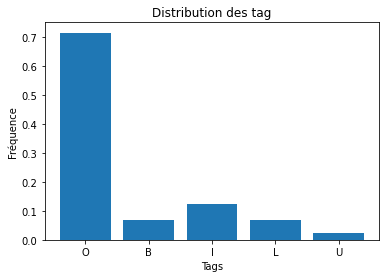

In [ ]:
show_distrib(train_tags)

***REMARQUE***
on remarque que le jeu de données est très déséquilibré.

## b.&c. Models et Evaluations

### CRF simple

On utilise le modèle proposé par le tutoriel en ligne CRF avec l'algorithme L-BFGS et Elastic Net avec les régulariseur (L1 + L2).

https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html#training

#### Prétraitement

In [ ]:
# we define the input of our CRF by addind the POS tag for each sentence, 
# we need them for the features of our CRF
X_crf_train= nltk.pos_tag_sents(train_sentences)
X_crf_val = nltk.pos_tag_sents(val_sentences)
X_crf_test = nltk.pos_tag_sents(test_sentences)

#### Definition du Model

In [ ]:
# Features have been chosen based on what has been done on other models found on the internet and logical sense
def features(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    word = sentence[index][0]
    postag = sentence[index][1]

    features = {
        'bias': 1.0,
        'word': word,
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'prev_word': '' if index == 0 else sentence[index - 1][0],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1][0],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
        'postag[:-2]': postag[:-2],
    }
    if index > 0:
        word1 = sentence[index-1][0]
        postag1 = sentence[index-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })

    if index < len(word)-1:
        word1 = sentence[index+1][0]
        postag1 = sentence[index+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    return features

In [ ]:
def transform_to_dataset(tagged_sentences):
    X= []
    for tagged in tagged_sentences:
      X.append([features(tagged, index) for index in range(len(tagged))])
 
    return X
CRF_train_sentences = transform_to_dataset(X_crf_train)

#### Entrainement d'un model

In [ ]:
 model_CRF_tacheA_ = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
    )

model_CRF_tacheA_.fit(CRF_train_sentences, train_tags)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [ ]:
model_CRF_tacheA = model_CRF_tacheA_

#### Grid search

In [ ]:
'''
model_CRF_tacheA = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
    )

params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

labels = list(model_CRF_tacheA_.classes_)
labels.remove('O')

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(model_CRF_tacheA, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(CRF_train_sentences, train_tags)
'''

"\nmodel_CRF_tacheA = CRF(\n    algorithm='lbfgs',\n    max_iterations=100,\n    all_possible_transitions=True\n    )\n\nparams_space = {\n    'c1': scipy.stats.expon(scale=0.5),\n    'c2': scipy.stats.expon(scale=0.05),\n}\n\nlabels = list(model_CRF_tacheA_.classes_)\nlabels.remove('O')\n\n# use the same metric for evaluation\nf1_scorer = make_scorer(metrics.flat_f1_score,\n                        average='weighted', labels=labels)\n\n# search\nrs = RandomizedSearchCV(model_CRF_tacheA, params_space,\n                        cv=3,\n                        verbose=1,\n                        n_jobs=-1,\n                        n_iter=50,\n                        scoring=f1_scorer)\nrs.fit(CRF_train_sentences, train_tags)\n"

In [ ]:
'''
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))
'''

"\nprint('best params:', rs.best_params_)\nprint('best CV score:', rs.best_score_)\nprint('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))\n"

In [ ]:
#model_CRF_tacheA = rs.best_estimator_

#### prediction

In [ ]:
def tag_prediction(sentences, model):
  X= []
  Y= []
  
  for tagged in sentences:
    sentence_features=[features(tagged, index) for index in range(len(tagged))]
    X.append(sentence_features)
    y_pred = model.predict([sentence_features])[0]
    Y.append(y_pred)
  return X, Y
 
CRF_train_sentences, y_train_pred = tag_prediction(X_crf_train,model_CRF_tacheA)
CRF_val_sentences, y_val_pred = tag_prediction(X_crf_val,model_CRF_tacheA)
CRF_test_sentences, y_test_pred = tag_prediction(X_crf_test,model_CRF_tacheA)


#### Evaluation on train and val set

In [ ]:
def CRF_show_confusion(y_true, y_pred):
  print(f"f1 micro:{f1_score(y_true, y_pred, average='micro'):.3f}")
  print(f"f1 micro:{f1_score(y_true, y_pred, average='macro'):.3f}")
  print(f"recall macro:{recall_score(y_true, y_pred, average='macro'):.3f}")
  print("Confusion Matrix:")
  print(confusion_matrix(y_true, y_pred))

In [ ]:
labels = list(model_CRF_tacheA.classes_)
labels.remove('O')
print(metrics.flat_f1_score(list(np.concatenate(val_tags)), list(np.concatenate(y_val_pred)),
      average='weighted', labels=labels))

0.47435081824155995


In [ ]:
print(metrics.flat_accuracy_score(val_tags, y_val_pred))

0.7748409640713197


In [ ]:
CRF_show_confusion(list(np.concatenate(val_tags)), list(np.concatenate(y_val_pred)))

f1 micro:0.775
f1 micro:0.559
recall macro:0.539
Confusion Matrix:
[[ 324  109    1  248   12]
 [  71  462   43  482   14]
 [   0   54  407  224    9]
 [ 241  544  193 7335   27]
 [  37   29   29  146  120]]


In [ ]:
# labels results
labels = model_CRF_tacheA.classes_
print(labels)
print(metrics.flat_classification_report(
    y_val_pred, val_tags, labels=labels, digits=3
))

['O', 'B', 'L', 'U', 'I']
              precision    recall  f1-score   support

           O      0.879     0.870     0.875      8435
           B      0.467     0.481     0.474       673
           L      0.586     0.605     0.595       673
           U      0.332     0.659     0.442       182
           I      0.431     0.386     0.407      1198

    accuracy                          0.775     11161
   macro avg      0.539     0.600     0.559     11161
weighted avg      0.780     0.775     0.776     11161



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B', 'L', 'U', 'I'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


***Remarque***

Le CRF simple nous donne des résultats assez médiocres, on ne s'attendait pas à ce qu'il dépasse les state of the art mais nous l'avons implémenté pour évaluer le modèle et le tester tout simplement. On remarque que le déséquilibre du jeu de données se ressent dans les résultats avec plus de 'O' prédis. Par contre le CRF propose des résultats qui restent correctes.

#### Submission file for CRF

In [102]:

y_val_csv=list(np.concatenate(y_val_pred))

CRF_val_df_soumission=val_df.drop(['DocID', 'Token'], 1)
CRF_val_df_soumission['Tag']=y_val_csv
CRF_val_df_soumission

CRF_val_df_soumission.to_csv('CRF_submission_val_A.csv', index=False, encoding='utf-8')


In [103]:
y_test_csv=list(np.concatenate(y_test_pred))

CRF_test_df_soumission=test_df.drop(['DocID', 'Token'], 1)
CRF_test_df_soumission['Tag']=y_test_csv
CRF_test_df_soumission

CRF_test_df_soumission.to_csv('CRF_submission_test_A.csv', index=False, encoding='utf-8')

### BI LSTM et Glove-Bilstm-CRF

#### Prétraitement

In [ ]:
# we define the words through numbers/index to save space
words, tags = set(), set()
 
for s in train_sentences:
  words = words.union(set(s))
 
for ts in train_tags:
  tags = tags.union(set(ts))
 
word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0  # The special value used for padding
word2index['-OOV-'] = 1  # The special value used for OOVs
 
# defining tag to index mapping
tag2index = {t: i + 1 for i, t in enumerate(list(tags))}
tag2index['-PAD-'] = 0  # The special value used to padding
index2tag={value: key for (key, value) in tag2index.items()}

print(tag2index)
print(index2tag)

In [ ]:
def get_sentence_X(sentences):
  sentences_X = []
  for s in sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    sentences_X.append(s_int)
  return sentences_X
  
train_sentences_X_no_pad = get_sentence_X(train_sentences)
val_sentences_X_no_pad   = get_sentence_X(val_sentences)
test_sentences_X_no_pad  = get_sentence_X(test_sentences)

train_tags_y_no_pad = [[tag2index[t] for t in s] for s in train_tags]
val_tags_y_no_pad   = [[tag2index[t] for t in s] for s in val_tags]
 
print(train_sentences_X_no_pad[0])
print(val_sentences_X_no_pad[0])
print(train_tags_y_no_pad[0])
print(val_tags_y_no_pad[0])

print('\n',test_sentences_X_no_pad[0])

[5612, 1238, 1447, 8464, 4901, 5266, 3634, 3814, 6457, 4901, 5266, 7145, 5148, 6393, 7371, 8672, 849, 6328, 5282, 5222, 4902, 4903, 2228, 2304, 8268, 6421, 1447, 3318, 8989, 1291, 8672, 2408, 7447, 7931, 7625, 2614, 4901, 454, 2637, 7931, 806, 2614, 4267, 8528, 6941, 2304, 8268, 6421, 1447, 3886, 5148, 8189, 8984, 6602, 6941, 8989, 1291, 8672, 3718, 1087, 4563, 7931, 4831, 2614, 4901, 5675, 8953, 7081, 7931, 4611, 2614, 4267, 8672, 746, 4657, 6838, 1238, 5489, 4903, 6941, 2304, 5664, 4903, 2902, 1733, 8984, 6602, 6941, 2721, 9001, 5466, 2228, 4901, 8984, 3415, 1896, 8672, 3494, 4656, 4901, 4678, 4052, 8127, 8856, 4360, 4901, 192, 8044, 3830, 7082, 8672, 4393, 1292, 949, 140, 6941, 2304, 8268, 6602, 6941, 1923, 3886, 5148, 6602, 4077, 4985, 192, 2073, 4901, 1291, 8672, 6754, 5148, 3453, 4901, 5148, 8268, 3546, 408, 5282, 5222, 153, 8888, 8672, 2843, 6941, 192, 7275, 5148, 5282, 9001, 4550, 4286, 5148, 1195, 8672, 1538, 2304, 8285, 1089, 9034, 3419, 8942, 8463, 3569, 1956, 8989, 8528, 45

In [ ]:
# defininf the length of the longest sentence in the whole dataset
MAX_LENGTH_train = len(max(train_sentences_X_no_pad, key=len))
MAX_LENGTH_val = len(max(val_sentences_X_no_pad, key=len))
MAX_LENGTH_test = len(max(test_sentences_X_no_pad, key=len))
MAX_LENGTH=max(MAX_LENGTH_train , MAX_LENGTH_val,MAX_LENGTH_test)
print(MAX_LENGTH)

350


In [ ]:
# Pad the sentences for bilstm entry
 
train_sentences_X = pad_sequences(train_sentences_X_no_pad, maxlen=MAX_LENGTH, padding='post')
val_sentences_X = pad_sequences(val_sentences_X_no_pad, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(test_sentences_X_no_pad, maxlen=MAX_LENGTH, padding='post')

train_tags_y = pad_sequences(train_tags_y_no_pad, maxlen=MAX_LENGTH, padding='post')
val_tags_y = pad_sequences(val_tags_y_no_pad, maxlen=MAX_LENGTH, padding='post')

train_tags_y = to_categorical(train_tags_y)
val_tags_y = to_categorical(val_tags_y)

print(train_sentences_X[0])
print(train_tags_y[0])

[5612 1238 1447 8464 4901 5266 3634 3814 6457 4901 5266 7145 5148 6393
 7371 8672  849 6328 5282 5222 4902 4903 2228 2304 8268 6421 1447 3318
 8989 1291 8672 2408 7447 7931 7625 2614 4901  454 2637 7931  806 2614
 4267 8528 6941 2304 8268 6421 1447 3886 5148 8189 8984 6602 6941 8989
 1291 8672 3718 1087 4563 7931 4831 2614 4901 5675 8953 7081 7931 4611
 2614 4267 8672  746 4657 6838 1238 5489 4903 6941 2304 5664 4903 2902
 1733 8984 6602 6941 2721 9001 5466 2228 4901 8984 3415 1896 8672 3494
 4656 4901 4678 4052 8127 8856 4360 4901  192 8044 3830 7082 8672 4393
 1292  949  140 6941 2304 8268 6602 6941 1923 3886 5148 6602 4077 4985
  192 2073 4901 1291 8672 6754 5148 3453 4901 5148 8268 3546  408 5282
 5222  153 8888 8672 2843 6941  192 7275 5148 5282 9001 4550 4286 5148
 1195 8672 1538 2304 8285 1089 9034 3419 8942 8463 3569 1956 8989 8528
 4589 4267 7413 8528 7289  408 8674 1630 7931 4611 2614 8672 4690 4901
 6328 7214  259 5222 2385 8127 2435 5148 1470 8127 2601 5266 1616 1500
 7931 

#### Simple Bilstm

##### architecture du model

In [ ]:
def create_model(weights, optimizer):

  model = Sequential()
  model.add(InputLayer(input_shape=(MAX_LENGTH, )))
  model.add(Embedding(len(word2index), 128))
  model.add(Bidirectional(LSTM(256, return_sequences=True)))
  model.add(TimeDistributed(Dense(len(tag2index))))
  model.add(Activation('softmax'))
  
  model.compile(loss=weighted_categorical_crossentropy(weights),
                optimizer=optimizer,
                metrics=['accuracy', get_f1_micro, get_f1_macro],
                run_eagerly=True)
  return model

##### benchmark/grid search

In [ ]:
'''
tag2weights_list = [
                    {"-PAD-":1, 'O':1, 'U':1, 'I':1, 'B':1, 'L':1},
                    {"-PAD-":1, 'O':1, 'U':2, 'I':2, 'B':2, 'L':2},
                    {"-PAD-":1, 'O':1, 'U':10, 'I':10, 'B':10, 'L':10}
]
all_weights = [np.array([tag2weights[index2tag[i]] for i in range(len(tag2index))]) for tag2weights in tag2weights_list]
optimizers = [Adam(), SGD()]
models = [create_model(weights, optimizer) for weights in all_weights for optimizer in optimizers]
histories = []
for model in tqdm(models):
  histories.append(model.fit(train_sentences_X, train_tags_y, batch_size=32, epochs=15, validation_data=(val_sentences_X,val_tags_y), verbose=0))
metric_names = ['loss', 'accuracy']
params = [([tag2weights[index2tag[i]] for i in range(len(tag2index))], optimizer) for tag2weights in tag2weights_list for optimizer in ["adam", 'sgd']]
print_training(histories, metric_names, params)
#predictions_test = mymodel.predict(test_sentences_X)
'''

#### Bilstm-CRF avec glove embedding

In [ ]:
# fex parameters
MAX_LEN = MAX_LENGTH  # Max length of words
WORD_EMBEDDING_OUT_DIM = 300

tags_A = tag2index
n_tags_A = len(tags_A)
words_voc_A=list(set(train_df["Token"].values))
n_words_A = len(words_voc_A) +2
max_word_len_A = len(max(words_voc_A[1:], key=len))

##### Definition de la matrice d'embedding Glove

In [ ]:
# definition of the embedding matrix
words_not_found = []

embedding_matrix = np.zeros((n_words_A, WORD_EMBEDDING_OUT_DIM))

for word, i in word2index.items():
    if i >= n_words_A:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 1302


##### Définition du modéle Bilstm+Crf

On utilise la librairie tf2crf de pypi, qui est est un module permettant d'implémenter un layer crf sur tensorflow 2. Ici on utilise la fonction  ModelWithCRFLossDSCLoss qui permet d'uitiliser la fonction de cout DSC (Dice similarity coefficient) qui est trés pratique dans le cadre des données qui sont déséquilibrée. On utilise également de l'early stopping et un checkpoint conservant le meilleur modèle en terme d'accuracy sur le validation set. Finalement, un embedding glove est utilisé pour augementer nos performances. On compare également le GRU et le LSTM comme layers.

In [ ]:
def create_model_Bilstm_crf_A( optimizer,embedding_name,layer,dropout, unit):
  inputs = Input(shape=(MAX_LEN, ))
  if embedding_name == 'Glove':
    x = Embedding(input_dim=n_words_A, output_dim=WORD_EMBEDDING_OUT_DIM, input_length=MAX_LEN,weights=[embedding_matrix])(inputs)
  else:
    x = Embedding(input_dim=n_words_A, output_dim=WORD_EMBEDDING_OUT_DIM, input_length=MAX_LEN)(inputs)

  if layer == 'GRU':
    x = Bidirectional(GRU(units=unit, return_sequences=True, dropout=dropout))(x)
  else:
    x = Bidirectional(LSTM(units=unit, return_sequences=True, dropout=dropout))(x)
  crf = CRF(units=n_tags_A)
  output = crf(x)
  base_model = Model(inputs, output)
  model_crf = ModelWithCRFLossDSCLoss(base_model,sparse_target=False)
  model_crf.compile(optimizer=optimizer)
  return model_crf

##### Grid search sur plusieurs données 

Ici on lance un grid search avec plusieurs paramétres différents 

In [ ]:
optimizers = ['adam'] #['adam','rmsprop','SGD']#['rmsprop','adam','SGD','adadelta']#['Adam()', 'SGD()', 'RMSprop()','Adagrad()','Adadelta()']
all_dropouts = [0.3]
units = [10,64] #[10, 64, 150, 250]
embeddin_meth = ['Glove', None]#['Glove', None] 
models_bilstm_crf_param_A = [[optimizer,embedding_name,layer, dropout, unit] for unit in units for layer in ['GRU', 'LSTM'] for dropout in all_dropouts for optimizer in optimizers for embedding_name in  embeddin_meth ]
models_bilstm_crf_A= [create_model_Bilstm_crf_A( optimizer,embedding_name,layer, dropout, unit) for unit in units for layer in ['GRU', 'LSTM'] for dropout in all_dropouts for optimizer in optimizers for embedding_name in  embeddin_meth ]


In [ ]:
callback2_A = EarlyStopping(monitor='val_loss_val', patience=3)
histories_A_Bilstm_crf = []
for i,model in tqdm(enumerate(models_bilstm_crf_A)):
  checkpoint2_A = ModelCheckpoint("./models/Bilstm_crf/best_model_bilstm_A"+str(i)+".hdf5", monitor='val_val_accuracy', verbose=1,save_best_only=True, mode='auto', save_weights_only=True)
  histories_A_Bilstm_crf.append(model.fit(train_sentences_X, train_tags_y, batch_size=32, epochs=50, validation_data=(val_sentences_X,val_tags_y),callbacks=[checkpoint2_A,callback2_A],verbose=1))


0it [00:00, ?it/s]

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 408.1556 - accuracy: 0.8245
Epoch 00001: val_val_accuracy improved from -inf to 0.85314, saving model to ./models/Bilstm_crf/best_model_bilstm_A0.hdf5
11/11 [==============================] - 27s 872ms/step - loss: 408.1556 - accuracy: 0.8245 - val_loss_val: 319.8029 - val_val_accuracy: 0.8531
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 270.2895 - accuracy: 0.8632
Epoch 00002: val_val_accuracy improved from 0.85314 to 0.85428, saving model to ./models/Bilstm_crf/best_model_bilstm_A0.hdf5
11/11 [==============================] - 8s 717ms/step - loss: 270.2895 - accuracy: 0.8632 - val_loss_val: 220.0158 - val_val_accuracy: 0.8543
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 185.2820 - accuracy: 0.8650
Epoch 00003: val_val_accuracy improved from 0.85428 to 0.85495, saving model to ./models/Bilstm_crf/best_model_bilstm_A0.hdf5
11/11 [==============================] - 8s 715ms/

1it [04:12, 252.82s/it]

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 503.0184 - accuracy: 0.4878
Epoch 00001: val_val_accuracy improved from -inf to 0.42469, saving model to ./models/Bilstm_crf/best_model_bilstm_A1.hdf5
11/11 [==============================] - 17s 872ms/step - loss: 503.0184 - accuracy: 0.4878 - val_loss_val: 478.4823 - val_val_accuracy: 0.4247
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 375.8264 - accuracy: 0.5276
Epoch 00002: val_val_accuracy improved from 0.42469 to 0.42572, saving model to ./models/Bilstm_crf/best_model_bilstm_A1.hdf5
11/11 [==============================] - 8s 691ms/step - loss: 375.8264 - accuracy: 0.5276 - val_loss_val: 379.1693 - val_val_accuracy: 0.4257
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 288.1357 - accuracy: 0.5999
Epoch 00003: val_val_accuracy improved from 0.42572 to 0.76902, saving model to ./models/Bilstm_crf/best_model_bilstm_A1.hdf5
11/11 [==============================] - 8s 716ms/

2it [07:38, 225.00s/it]

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 742.4615 - accuracy: 0.1056
Epoch 00001: val_val_accuracy improved from -inf to 0.41778, saving model to ./models/Bilstm_crf/best_model_bilstm_A2.hdf5
11/11 [==============================] - 17s 863ms/step - loss: 742.4615 - accuracy: 0.1056 - val_loss_val: 617.0889 - val_val_accuracy: 0.4178
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 615.9537 - accuracy: 0.3342
Epoch 00002: val_val_accuracy improved from 0.41778 to 0.43000, saving model to ./models/Bilstm_crf/best_model_bilstm_A2.hdf5
11/11 [==============================] - 7s 674ms/step - loss: 615.9537 - accuracy: 0.3342 - val_loss_val: 503.7560 - val_val_accuracy: 0.4300
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 482.8935 - accuracy: 0.4193
Epoch 00003: val_val_accuracy improved from 0.43000 to 0.83572, saving model to ./models/Bilstm_crf/best_model_bilstm_A2.hdf5
11/11 [==============================] - 7s 674ms/

3it [12:16, 249.10s/it]

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 813.2711 - accuracy: 0.2275
Epoch 00001: val_val_accuracy improved from -inf to 0.26753, saving model to ./models/Bilstm_crf/best_model_bilstm_A3.hdf5
11/11 [==============================] - 17s 856ms/step - loss: 813.2711 - accuracy: 0.2275 - val_loss_val: 723.2390 - val_val_accuracy: 0.2675
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 590.4734 - accuracy: 0.4268
Epoch 00002: val_val_accuracy improved from 0.26753 to 0.47923, saving model to ./models/Bilstm_crf/best_model_bilstm_A3.hdf5
11/11 [==============================] - 9s 811ms/step - loss: 590.4734 - accuracy: 0.4268 - val_loss_val: 533.1318 - val_val_accuracy: 0.4792
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 412.7198 - accuracy: 0.6604
Epoch 00003: val_val_accuracy improved from 0.47923 to 0.66510, saving model to ./models/Bilstm_crf/best_model_bilstm_A3.hdf5
11/11 [==============================] - 10s 715ms

4it [16:57, 261.79s/it]

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 576.6807 - accuracy: 0.3084
Epoch 00001: val_val_accuracy improved from -inf to 0.57799, saving model to ./models/Bilstm_crf/best_model_bilstm_A4.hdf5
11/11 [==============================] - 21s 1s/step - loss: 576.6807 - accuracy: 0.3084 - val_loss_val: 424.4284 - val_val_accuracy: 0.5780
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 325.2778 - accuracy: 0.7910
Epoch 00002: val_val_accuracy improved from 0.57799 to 0.85485, saving model to ./models/Bilstm_crf/best_model_bilstm_A4.hdf5
11/11 [==============================] - 11s 1s/step - loss: 325.2778 - accuracy: 0.7910 - val_loss_val: 177.6390 - val_val_accuracy: 0.8548
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 136.8391 - accuracy: 0.8692
Epoch 00003: val_val_accuracy improved from 0.85485 to 0.85629, saving model to ./models/Bilstm_crf/best_model_bilstm_A4.hdf5
11/11 [==============================] - 11s 1s/step - 

5it [20:15, 238.66s/it]

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 430.8212 - accuracy: 0.6677
Epoch 00001: val_val_accuracy improved from -inf to 0.84036, saving model to ./models/Bilstm_crf/best_model_bilstm_A5.hdf5
11/11 [==============================] - 20s 1s/step - loss: 430.8212 - accuracy: 0.6677 - val_loss_val: 335.6440 - val_val_accuracy: 0.8404
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 242.3040 - accuracy: 0.8585
Epoch 00002: val_val_accuracy improved from 0.84036 to 0.85041, saving model to ./models/Bilstm_crf/best_model_bilstm_A5.hdf5
11/11 [==============================] - 11s 988ms/step - loss: 242.3040 - accuracy: 0.8585 - val_loss_val: 223.6375 - val_val_accuracy: 0.8504
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 172.8817 - accuracy: 0.8631
Epoch 00003: val_val_accuracy improved from 0.85041 to 0.85454, saving model to ./models/Bilstm_crf/best_model_bilstm_A5.hdf5
11/11 [==============================] - 11s 1s/step

6it [22:47, 209.34s/it]

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 564.8522 - accuracy: 0.4661
Epoch 00001: val_val_accuracy improved from -inf to 0.83459, saving model to ./models/Bilstm_crf/best_model_bilstm_A6.hdf5
11/11 [==============================] - 22s 1s/step - loss: 564.8522 - accuracy: 0.4661 - val_loss_val: 406.6782 - val_val_accuracy: 0.8346
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 277.0113 - accuracy: 0.8587
Epoch 00002: val_val_accuracy improved from 0.83459 to 0.84608, saving model to ./models/Bilstm_crf/best_model_bilstm_A6.hdf5
11/11 [==============================] - 13s 1s/step - loss: 277.0113 - accuracy: 0.8587 - val_loss_val: 213.7614 - val_val_accuracy: 0.8461
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 183.2888 - accuracy: 0.8564
Epoch 00003: val_val_accuracy improved from 0.84608 to 0.85062, saving model to ./models/Bilstm_crf/best_model_bilstm_A6.hdf5
11/11 [==============================] - 13s 1s/step - 

7it [27:32, 234.02s/it]

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 553.8858 - accuracy: 0.4223
Epoch 00001: val_val_accuracy improved from -inf to 0.47031, saving model to ./models/Bilstm_crf/best_model_bilstm_A7.hdf5
11/11 [==============================] - 23s 1s/step - loss: 553.8858 - accuracy: 0.4223 - val_loss_val: 422.5653 - val_val_accuracy: 0.4703
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 302.7005 - accuracy: 0.6211
Epoch 00002: val_val_accuracy improved from 0.47031 to 0.84443, saving model to ./models/Bilstm_crf/best_model_bilstm_A7.hdf5
11/11 [==============================] - 13s 1s/step - loss: 302.7005 - accuracy: 0.6211 - val_loss_val: 256.1518 - val_val_accuracy: 0.8444
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 201.6654 - accuracy: 0.8563
Epoch 00003: val_val_accuracy improved from 0.84443 to 0.85206, saving model to ./models/Bilstm_crf/best_model_bilstm_A7.hdf5
11/11 [==============================] - 13s 1s/step - 

8it [31:47, 238.47s/it]


##### résulats du grid search

In [ ]:
#on importe les meilleurs modèles 
val_true=np.argmax(val_tags_y, axis=-1)

grid_search_results_A = pd.DataFrame(columns=['model', 'f1 score micro','f1 score macro'])
grid_search_results_A['model'] = models_bilstm_crf_param_A

f1_scores_micro=[]
f1_scores_macro=[]

f1_score_selected=0
for i in range(len(models_bilstm_crf_A)):
  # Restore the weights
  model_i = models_bilstm_crf_A[i]
  model_i.load_weights("./models/Bilstm_crf/best_model_bilstm_A"+str(i)+".hdf5")
  val_pred_ner_i = model_i.predict(val_sentences_X)
  
  
  f1_score_micro = f1_score(val_true.flatten(), val_pred_ner_i.flatten(), average='micro')
  f1_score_macro = f1_score(val_true.flatten(), val_pred_ner_i.flatten(), average='macro')
  f1_scores_micro.append(f1_score_micro)
  f1_scores_macro.append(f1_score_macro)
  if f1_score_macro >= f1_score_selected:
    model_selected = model_i
    f1_score_selected = f1_score_macro


In [ ]:
grid_search_results_A['f1 score micro'] = f1_scores_micro
grid_search_results_A['f1 score macro'] = f1_scores_macro
grid_search_results_A

,model,f1 score micro,f1 score macro
0,"[adam, Glove, GRU, 0.3, 10]",0.875309,0.570776
1,"[adam, None, GRU, 0.3, 10]",0.870000,0.535713
2,"[adam, Glove, LSTM, 0.3, 10]",0.866237,0.428373
3,"[adam, None, LSTM, 0.3, 10]",0.863093,0.483890
4,"[adam, Glove, GRU, 0.3, 64]",0.884124,0.616138
5,"[adam, None, GRU, 0.3, 64]",0.873196,0.572482
6,"[adam, Glove, LSTM, 0.3, 64]",0.874845,0.575239
7,"[adam, None, LSTM, 0.3, 64]",0.875464,0.547626


***REMARQUE***
on remarque que l'embedding Glove donne en général de meilleurs résultats. De plus le GRU offre également les meilleurs résultats avec un meilleur score f1 score macro de 0.61 et micro de 0.88. Ce résulat est associé à un plus grand nombreux d'unités (64) et un embedding glove.

##### Modèle sélectionné

In [ ]:
model_sected=models_bilstm_crf_A[0]
callback2_A = EarlyStopping(monitor='val_loss_val', patience=3)
checkpoint2_A = ModelCheckpoint("./models/Bilstm_crf/best_model_bilstm_A_select.hdf5", monitor='val_val_accuracy', verbose=1,save_best_only=True, mode='auto', save_weights_only=True)

model_sected.fit(train_sentences_X, train_tags_y, batch_size=32, epochs=50, validation_data=(val_sentences_X,val_tags_y),callbacks=[checkpoint2_A,callback2_A],verbose=1)

##### Evaluation du modèle (confusion matrix et autre metrics)

In [ ]:
val_pred_ner = model_selected.predict(val_sentences_X)
labels_for_confusion_m= range(len(tags_A))
show_confusion_bis(val_true.flatten(), val_pred_ner.flatten(),labels=labels_for_confusion_m)

f1 micro:0.875
f1 macro:0.548
recall macro:0.523
Confusion Matrix:
[[8239    0    0    0    0    0]
 [   2 7852  203  146  124   13]
 [   0  346  284   53    6    5]
 [   0  617  123  255   72    5]
 [   2  322   14   25  324    7]
 [   2  225   67   10   27   30]]


In [ ]:
print(classification_report(val_true.flatten(), val_pred_ner.flatten(), target_names=tags_A))

              precision    recall  f1-score   support

           O       1.00      1.00      1.00      8239
           B       0.84      0.94      0.89      8340
           I       0.41      0.41      0.41       694
           L       0.52      0.24      0.33      1072
           U       0.59      0.47      0.52       694
       -PAD-       0.50      0.08      0.14       361

    accuracy                           0.88     19400
   macro avg       0.64      0.52      0.55     19400
weighted avg       0.86      0.88      0.86     19400



***Remarque***

On remarque que notre modèle apprend bien les valeurs évidentes comme les valeurs de padding qui sont à zéros. En vu de notre jeu de données qui est très déséquilibrés on s'attend donc à ce que notre modèle prédit beacoup de 'O', ce qui nous donne certes une  bonne precision, recall et f1 score pour le O mais des résultats moyens poour le 'I' par exemple et autre. Le 'B' est également plûtot bien prédit, nous pensons que la couche CRF permet en effet d'ajouter des éléments de logiques permettant d'améliorer nos résultats. En effet, on a testé un modèle Bilstm simple sans CRF et nous avionns de moins bon résultats.


NB: pour les valeurs du padding qui sont à 0 nous aurions pu utiliser l'argument masking=0 pour l'embedding mais cela nous donnait de moins bon résultats étonnement.

##### création des fichiers de soumissions pour la validation et le test

In [ ]:
def suppress_pad(test_tags_y_predict,test_sentences_X_no_pad):
  # we supress the 0s correponding to the additional padding
  #test_tags_y_predict_no_pad = np.delete(test_tags_y_predict[0], np.where(test_tags_y_predict[0] == 0))
  test_tags_y_predict_no_pad = test_tags_y_predict[0][:len(test_sentences_X_no_pad[0])]
  for i in range (1,len(test_tags_y_predict)):
    A_i=test_tags_y_predict[i][:len(test_sentences_X_no_pad[i])]
    test_tags_y_predict_no_pad = np.concatenate((test_tags_y_predict_no_pad ,A_i))
    
    if len(test_sentences_X_no_pad[i])!=len(A_i):
      print(len(A_i))
      print(len(test_sentences_X_no_pad[i]))
      print("FALSE:",i)
  
  return test_tags_y_predict_no_pad

In [ ]:
val_pred_ner = model_selected.predict(val_sentences_X)
val_pred_ner_no_pad = suppress_pad(val_pred_ner,val_sentences_X_no_pad)
submission_val_bilstm_crf_A = pd.DataFrame(columns = ['TokenID', 'Tag'])
submission_val_bilstm_crf_A['TokenID'] = val_df['TokenID']
#submission_val_bilstm_crf_A['Tag'] = val_pred_ner_no_pad

val_ids_concat = np.concatenate(val_ids)
for i in tqdm(range(len(val_df))):
  k = val_df[val_df["TokenID"] == val_ids_concat[i]].index[0]
  submission_val_bilstm_crf_A.at[k, "Tag"] = val_pred_ner_no_pad[i]


submission_val_bilstm_crf_A['Tag'] = submission_val_bilstm_crf_A['Tag'].map(index2tag)
submission_val_bilstm_crf_A

100%|██████████| 11161/11161 [00:14<00:00, 775.02it/s]


,TokenID,Tag
0,S0301010415300355-0,O
1,S0301010415300355-1,O
2,S0301010415300355-2,O
3,S0301010415300355-3,O
4,S0301010415300355-4,O
...,...,...
11156,S1359028614000989-185,O
11157,S1359028614000989-186,O
11158,S1359028614000989-187,O
11159,S1359028614000989-188,O


In [ ]:
test_pred_ner = model_selected.predict(test_sentences_X)
test_pred_ner_no_pad = suppress_pad(test_pred_ner,test_sentences_X_no_pad)
submission_test_bilstm_crf_A = pd.DataFrame(columns = ['TokenID', 'Tag'])
submission_test_bilstm_crf_A['TokenID'] = test_df['TokenID']
#submission_test_bilstm_crf_A['Tag'] = test_pred_ner_no_pad

test_ids_concat = np.concatenate(test_ids)
for i in tqdm(range(len(test_df))):
  k = test_df[test_df["TokenID"] == test_ids_concat[i]].index[0]
  submission_test_bilstm_crf_A.at[k, "Tag"] = test_pred_ner_no_pad[i]

submission_test_bilstm_crf_A['Tag'] = submission_test_bilstm_crf_A['Tag'].map(index2tag)
submission_test_bilstm_crf_A

100%|██████████| 21711/21711 [00:42<00:00, 516.10it/s]


,TokenID,Tag
0,S0885230816301759-0,O
1,S0885230816301759-1,O
2,S0885230816301759-2,O
3,S0885230816301759-3,O
4,S0885230816301759-4,B
...,...,...
21706,S1877750313001269-211,O
21707,S1877750313001269-212,O
21708,S1877750313001269-213,O
21709,S1877750313001269-214,O


In [ ]:
submission_test_bilstm_crf_A.to_csv('Test_submission_Glove_Bilstm_CRF_tache_A.csv',index=False)
submission_val_bilstm_crf_A.to_csv('Val_submission_Glove_Bilstm_CRF_tache_A.csv',index=False)

### BERT

#### Imports

In [ ]:
!pip install transformers

In [ ]:
import transformers
from transformers import BertTokenizer
from transformers import BertForTokenClassification, AdamW, BertConfig, BertModel
from transformers import get_linear_schedule_with_warmup

from tensorflow.keras.preprocessing.sequence import pad_sequences

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from nltk.tokenize import sent_tokenize

import matplotlib.pyplot as plt
import seaborn as sns

import time
import random
import numpy as np
import datetime

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


#### Preprocessing for BERT

Since BERT is a massive architecture we can no longer use entire documents ans we need to use sentences instead. Indee the maximal length of the documents is around 350 whereas the maximal length of the sentences is around 200.  
Since we don't have clear sentence delimitation in the .csv documents, we use nltk sentence tokenizer on the .txt documents and then the nltk word tokenizer on the sentences. Finally we sequentially attribute the labels we got in the previous parts to the tokens we just optained. Unfortunatly, it seems that the .cvs files don't exactly used this technic to optain their tokens because some sentences are missing points or some token we optaned correspond to several tokens in the csv file.  
When the problem is just a missing point we add it. When tokens are not the same with the two tokenization strategy, since these examples are very rare, we just delete them from the dataset.

In [ ]:
# We retrieve the texts directly from the .txt files to apply the sentence tokeniezer
def get_text_docs(folder):
  text_docs = []
  print("Loading docs...")
  for i, doc_id in enumerate(tqdm(doc_ids[folder])):
    with open(f"data/{folder}/{doc_id}.txt", "r") as file:
      text = file.read()[:-1]
    text_docs.append(text)
  print("   DONE.")
  print()
  return text_docs


In [ ]:
# We then construct the tokenized sentences and assign the labels

def get_doc_sentences(text_docs, folder, original_sentences, doc_tags, ids=None):
  # We construct the list sentences (list of tokens) based on nltk sent_tokenize and nltk world_tokenizer
  doc_sentences0 = []
  print("Constructing sentences...")
  for text in tqdm(text_docs):
    doc_sentences0.append([np.array(word_tokenize(sent), dtype=str) for sent in sent_tokenize(text)])
  diff = 0
  invalid_indices = []
  print()
  for i, (sentences, tokens) in enumerate(zip(doc_sentences0, original_sentences)):
    sentence_tokens = np.concatenate(sentences)
    if sentence_tokens.size != tokens.size:
      doc_sentences0[i][-1] = np.concatenate([doc_sentences0[i][-1], np.array(["."])])
      if np.concatenate(doc_sentences0[i]).size != tokens.size:
        # When sent_tokenizer + word_tokenizer doesn't match the tokens form the .csv file
        print(f" Doc {doc_ids[folder][i]} invalid")
        invalid_indices.append(i)
        print(list(np.concatenate(doc_sentences0[i])))
        print(list(tokens))
        print()
  
  print("   DONE.")
  print()
    
  # Since we noticed there is only one sentence in the dataset that is wrongly tokenized, we simply delete it from dataset
  doc_sentences = [doc_sentences0[i] for i in range(len(doc_sentences0)) if i not in invalid_indices]
  if doc_tags is not None: tags_valid = [doc_tags[i] for i in range(len(doc_tags)) if i not in invalid_indices]

  # Setting tags to the new tokens
  if doc_tags is not None: 
    doc_tags_ = []
    for tags, sentences in zip(tags_valid, doc_sentences):
      doc_tags_.append([])
      n = 0
      for sentence in sentences:
        doc_tags_[-1].append(np.array(tags[n:n+len(sentence)]))
        n += len(sentence)
  
  # We flatten the doc_sentences structure to have only one list of sentence independently of the documents
  all_sentences = [sentence for sentences in doc_sentences for sentence in sentences]
  if doc_tags is not None: 
    all_tags = [tags for sentence_tags in doc_tags_ for tags in sentence_tags]
    print("Same number of sentences and tag sequences:", len(all_sentences) == len(all_tags))
    if len(all_sentences) == len(all_tags):
      print("Size:",len(all_sentences))

    print("Looking at some sentences randomly:")
    for i in np.random.choice(range(len(all_sentences)), size=5):
      print(list(zip(all_sentences[i], all_tags[i])))

  else: all_tags = None
  
  return all_sentences, all_tags

In [ ]:
print("==== Train dataset ====")
all_sentences_train, all_tags_train = get_doc_sentences(get_text_docs('train'), 'train', train_sentences, train_tags)
print()
print()
print("==== Validation dataset ====")
all_sentences_val, all_tags_val = get_doc_sentences(get_text_docs('val'), 'val', val_sentences, val_tags)

==== Train dataset ====
Loading docs...


100%|██████████| 350/350 [00:58<00:00,  5.94it/s]


   DONE.

Constructing sentences...


100%|██████████| 350/350 [00:00<00:00, 441.52it/s]



 Doc S0370269304009359 invalid
['Table', '1', 'lists', '8', 'pairs', 'of', 'B', 'decays', '.', 'In', 'fact', ',', 'there', 'are', 'more', 'decay', 'pairs', ',', 'since', 'many', 'of', 'the', 'particles', 'in', 'the', 'final', 'states', 'can', 'be', 'observed', 'as', 'either', 'pseudoscalar', '(', 'P', ')', 'or', 'vector', '(', 'V', ')', 'mesons', '.', 'Note', 'that', 'certain', 'decays', 'are', 'written', 'in', 'terms', 'of', 'VV', 'final', 'states', ',', 'while', 'others', 'are', 'have', 'PP', 'states', '.', 'There', 'are', 'three', 'reasons', 'for', 'this', '.', 'First', ',', 'some', 'decays', 'involve', 'a', 'final-state', 'π0', '.', 'However', ',', 'experimentally', 'it', 'will', 'be', 'necessary', 'to', 'find', 'the', 'decay', 'vertices', 'of', 'the', 'final', 'particles', '.', 'This', 'is', 'virtually', 'impossible', 'for', 'a', 'π0', ',', 'and', 'so', 'we', 'always', 'use', 'a', 'ρ0', '.', 'Second', ',', 'some', 'pairs', 'of', 'decays', 'are', 'related', 'by', 'SU', '(', '3', '

100%|██████████| 50/50 [00:07<00:00,  6.32it/s]


   DONE.

Constructing sentences...


100%|██████████| 50/50 [00:00<00:00, 359.26it/s]


   DONE.

Same number of sentences and tag sequences: True
Size: 413
Looking at some sentences randomly:
[('Under', 'O'), ('the', 'O'), ('assumption', 'O'), ('that', 'O'), ('the', 'O'), ('noise', 'O'), ('present', 'O'), ('above', 'O'), ('1023Hz', 'O'), ('is', 'O'), ('negligible', 'O'), ('compared', 'O'), ('with', 'O'), ('the', 'O'), ('noise', 'O'), ('present', 'O'), ('below', 'O'), ('0.5Hz', 'O'), (',', 'O'), ('this', 'O'), ('procedure', 'O'), ('enables', 'O'), ('an', 'O'), ('accurate', 'B'), ('recording', 'I'), ('of', 'I'), ('the', 'I'), ('potential', 'I'), ('noise', 'I'), ('in', 'I'), ('the', 'I'), ('frequencies', 'I'), ('of', 'I'), ('interest', 'L'), (',', 'O'), ('avoiding', 'O'), ('aliasing', 'O'), ('of', 'O'), ('frequencies', 'O'), ('between', 'O'), ('0.5', 'O'), ('and', 'O'), ('1023Hz', 'O'), ('and', 'O'), ('minimizing', 'O'), ('the', 'O'), ('50Hz', 'O'), ('interference', 'O'), ('from', 'O'), ('the', 'O'), ('mains', 'O'), ('supply', 'O'), ('.', 'O')]
[('This', 'O'), ('particular

In [ ]:
lengths = []
print('Measuring lengths')
for sen in tqdm(all_sentences_train + all_sentences_val):
    sen = ' '.join(sen)
    encoded_sent = tokenizer.encode(sen, add_special_tokens = True)
    
    lengths.append(len(encoded_sent))
print()
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('   Median length: {:,} tokens'.format(int(np.median(lengths))))

Measuring lengths


100%|██████████| 2815/2815 [00:03<00:00, 853.74it/s]


   Min length: 4 tokens
   Max length: 187 tokens
   Median length: 31 tokens


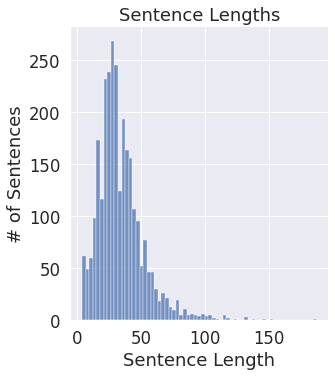

In [ ]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,5)

# Plot the distribution of comment lengths.
sns.displot(lengths, kde=False, rug=False)

plt.title('Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('# of Sentences')
plt.show()

In [ ]:
MAX_LEN = 200

In [ ]:
# Since we built our sentence with nltk tokenizers, we need to adapt the tagging system 
# We don't use the tutorial version because it doesn't consider, for example, that the character '-' is considered to devide a word for bert but not for nltk
null_tag = '-N-'
def tokenize_with_tags(tokens, tags):
  complete_tags = [null_tag]

  for token, tag in zip(tokens, tags):
    complete_tags += [tag] + [null_tag] * (len(tokenizer.tokenize(token)) - 1)
  complete_tags.append(null_tag)
  return complete_tags

In [ ]:
# This function is used for printing comprehensive representation of the data tokenized by BERT. 

def get_bert_token(token_id):
  token_id = token_id.numpy().item()
  if token_id == tokenizer.pad_token_id:
    return "PAD"
  elif token_id == tokenizer.cls_token_id:
    return "CLS"
  elif token_id == tokenizer.sep_token_id:
    return "SEP"
  else:
    return tokenizer.ids_to_tokens[token_id]

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# def pad_sequences(sequences, max_len, value,dtype=object):
#   ret = np.zeros((len(sequences),max_len), dtype=dtype)
#   for i, sequence in enumerate(sequences):
#     for j, elt in enumerate(sequence):
#       ret[i, j] = elt
#     ret[i,len(sequence):] = value
#     print(ret)
#     print()
#   return ret

In [ ]:
# a = [["aze", "fe", "e"]]
# pad_sequences(a, 10, value='N')

In [ ]:
# We construct final vectors, ready to be transformed into torch tensors.

def get_final_data(sentences, all_tags):
  if all_tags is not None: 
    print("Adapting tags to BERT tokenizer...")
    ta = [tokenize_with_tags(tokens, tags) for tokens, tags in tqdm(list(zip(sentences, all_tags)))]
    print("   DONE.")
    tags_tokenized = pad_sequences(ta, maxlen=MAX_LEN, dtype=object, value=null_tag, padding='post')
  else:
    tags_tokenized = None
  sentences_X = []
  attention_masks = []
  print("Applying BERT tokenizer to the sentences...")
  for tokens in tqdm(sentences):
    sentence = " ".join(tokens)
    encoded_dict = tokenizer(sentence, 
                      add_special_tokens=True, 
                      max_length=MAX_LEN,
                      padding="max_length", 
                      return_attention_mask=True, 
                      return_tensors ='pt')
    sentences_X.append(encoded_dict['input_ids'][0])
    attention_masks.append(encoded_dict['attention_mask'][0])
  print("   DONE.")
  print()
  if all_tags is not None:
    print("Looking at some sentences randomly:")
    for i in np.random.choice(range(len(sentences_X)), size=5):
      print(list(zip([get_bert_token(elt) for elt in sentences_X[i]], tags_tokenized[i], [elt.item() for elt in attention_masks[i]])))

  return sentences_X, attention_masks, tags_tokenized


In [ ]:
print("==== Train dataset ====")
train_sentences_X, train_attention_masks, train_tags_tokenized = get_final_data(all_sentences_train, all_tags_train)
print()
print()
print("==== Validation dataset ====")
val_sentences_X, val_attention_masks, val_tags_tokenized = get_final_data(all_sentences_val, all_tags_val)

==== Train dataset ====
Adapting tags to BERT tokenizer...


100%|██████████| 2402/2402 [00:06<00:00, 372.89it/s]


   DONE.
Applying BERT tokenizer to the sentences...


100%|██████████| 2402/2402 [00:03<00:00, 705.34it/s]


   DONE.

Looking at some sentences randomly:
[('CLS', '-N-', 1), ('micro', 'U', 1), ('##hard', '-N-', 1), ('##ness', '-N-', 1), ('can', 'O', 1), ('be', 'O', 1), ('related', 'O', 1), ('to', 'O', 1), ('other', 'O', 1), ('macro', 'O', 1), ('##scopic', '-N-', 1), ('mechanical', 'O', 1), ('properties', 'O', 1), ('such', 'O', 1), ('as', 'O', 1), ('yield', 'O', 1), ('stress', 'O', 1), (',', 'O', 1), ('σ', 'O', 1), (',', 'O', 1), ('and', 'O', 1), ('elastic', 'O', 1), ('mod', 'O', 1), ('##ulus', '-N-', 1), (',', 'O', 1), ('e', 'O', 1), (',', 'O', 1), ('both', 'O', 1), ('derived', 'O', 1), ('from', 'O', 1), ('compression', 'B', 1), ('testing', 'L', 1), ('.', 'O', 1), ('SEP', '-N-', 1), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-

100%|██████████| 413/413 [00:01<00:00, 361.57it/s]


   DONE.
Applying BERT tokenizer to the sentences...


100%|██████████| 413/413 [00:00<00:00, 734.14it/s]

   DONE.

Looking at some sentences randomly:
[('CLS', '-N-', 1), ('3', 'O', 1), (',', 'O', 1), ('each', 'O', 1), ('failed', 'B', 1), ('face', 'L', 1), ('is', 'O', 1), ('a', 'O', 1), ('graph', 'O', 1), ('node', 'O', 1), ('and', 'O', 1), ('each', 'O', 1), ('pair', 'O', 1), ('of', 'O', 1), ('neighbouring', 'O', 1), ('failed', 'B', 1), ('faces', 'L', 1), ('is', 'O', 1), ('a', 'O', 1), ('graph', 'O', 1), ('edge', 'O', 1), ('.', 'O', 1), ('SEP', '-N-', 1), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-', 0), ('PAD', '-N-

In [ ]:
# Map each unique label to an integer.
# label_map = {'N':-100} # we don't keep that to be able to apply one_hot encoding for custom BERT
label_map = {}

# For each label...
for (i, label) in enumerate(set([tag for L in train_tags_tokenized for tag in L])):
    
    # Map it to its integer.
    label_map[label] = i

In [ ]:
print(label_map)

{'O': 0, 'I': 1, '-N-': 2, 'U': 3, 'B': 4, 'L': 5}


In [ ]:
train_new_labels = [[label_map[elt] for elt in L] for L in train_tags_tokenized]
val_new_labels = [[label_map[elt] for elt in L] for L in val_tags_tokenized]

In [ ]:
# We construct the torch data structures that will be used for creating batches to pass to the different Bert models

def get_data_loader(sentences_X, attention_masks, new_labels, sampler):
  pt_input_ids = torch.stack(sentences_X, dim=0)
  pt_attention_masks = torch.stack(attention_masks, dim=0)
  if new_labels is not None: 
    pt_labels = torch.tensor(new_labels, dtype=torch.long)

    dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

  else:
    dataset = TensorDataset(pt_input_ids, pt_attention_masks)

  batch_size = 16
  dataloader = DataLoader(
            dataset,  # The training samples.
            sampler = sampler(dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
  return dataloader

In [ ]:
train_dataloader = get_data_loader(train_sentences_X, train_attention_masks, train_new_labels, RandomSampler)
validation_dataloader = get_data_loader(val_sentences_X, val_attention_masks, val_new_labels, SequentialSampler)

#### Model definition

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
def get_BertForTokenClassification(label_map):
  model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(label_map) + 1, # The number of output labels
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
  )
  return model

In [ ]:
# Here we difine different strategies for aggregating the last layers of Bert into a single vector to pass to the fine-tuned part

def Nth_layer(layer_list, N):
  """return layer at index N statring from the end. For example to get last lyer you should use N=0"""
  return layer_list[-(N+1)]

def get_Nth_layer(N):
  return lambda layer_list: Nth_layer(layer_list, N)

last_layer_alone = get_Nth_layer(0)

def mean_N_last_layer(layer_list, N):
  return torch.mean(torch.stack(layer_list[-N:]),dim=0)

def get_mean_N_last_layer(N):
  return lambda layer_list: mean_N_last_layer(layer_list, N)
  


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel

class BertCustom(nn.Module):
    def __init__(self, aggregation_stategy=last_layer_alone, H=50, freeze_bert=False):
        super(BertCustom, self).__init__()
        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Bert-base embedding have dim 768
        D_in, H, D_out =  768, H, len(label_map) + 1

        # Instantiate an one-layer feed-forward network
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        self.aggregation_stategy = aggregation_stategy
        
    def forward(self, input_ids, attention_mask,labels):
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            output_hidden_states=True)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        hidden_state_aggregation = self.aggregation_stategy(outputs.hidden_states)

        # Feed input to classifier to compute logits
        logits = self.classifier(hidden_state_aggregation)

        # Compute loss
        if labels is None:
          return logits, None

        loss_fn = nn.CrossEntropyLoss()

        cat_labels = nn.functional.one_hot(labels, len(label_map) + 1).type(torch.float32)
        cat_labels.to(device)

        loss = loss_fn(logits,cat_labels)
        return logits, loss

In [ ]:
def get_Bert_custom(aggregation_stategy=last_layer_alone,H=50):
  return BertCustom(aggregation_stategy=aggregation_stategy, H=H)

#### Model training and saving explicit

In [ ]:
# Load model 
# model = get_Bert_custom(aggregation_stategy=get_mean_N_last_layer(6))
model = get_BertForTokenClassification(label_map)

# # Tell pytorch to run this model on the GPU.
model = model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [ ]:
# Load the AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate 
                  eps = 1e-8 # args.adam_epsilon 
                )


In [ ]:
# Number of training epochs 
epochs = 5

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
  # print(i)
  # print(isinstance(model,BertClassifier))
    
  # ========================================
  #               Training
  # ========================================
  
  # Perform one full pass over the training set.

  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
  print('Training...')

  # Measure how long the training epoch takes.
  t0 = time.time()

  # Reset the total loss for this epoch.
  total_loss = 0

  # Put the model into training mode. Don't be mislead--the call to 
  # `train` just changes the *mode*, it doesn't *perform* the training.
  # `dropout` and `batchnorm` layers behave differently during training
  # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
  model.train()

  # For each batch of training data...
  for step, batch in enumerate(tqdm(train_dataloader)):

      # Unpack this training batch from our dataloader. 
      #
      # As we unpack the batch, we'll also copy each tensor to the GPU using the 
      # `to` method.
      #
      # `batch` contains three pytorch tensors:
      #   [0]: input ids 
      #   [1]: attention masks
      #   [2]: labels 
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

      # Always clear any previously calculated gradients before performing a
      # backward pass. PyTorch doesn't do this automatically because 
      # accumulating the gradients is "convenient while training RNNs". 
      # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
      model.zero_grad()        

      # In PyTorch, calling `model` will in turn call the model's `forward` 
      # function and pass down the arguments. The `forward` function is 
      # documented here: 
      # https://huggingface.co/transformers/model_doc/bert.html#bertfortokenclassification
      # The results are returned in a results object, documented here:
      # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.TokenClassifierOutput
      
      if isinstance(model,BertCustom):
        logits,loss = model(b_input_ids,
                  attention_mask=b_input_mask,
                  labels=b_labels)
      else:
        result = model(b_input_ids, 
                  token_type_ids=None, 
                  attention_mask=b_input_mask
                  ,labels=b_labels)
        loss = result.loss

      # Accumulate the training loss over all of the batches so that we can
      # calculate the average loss at the end. `loss` is a Tensor containing a
      # single value; the `.item()` function just returns the Python value 
      # from the tensor.
      total_loss += loss.item()

      # Perform a backward pass to calculate the gradients.
      loss.backward()

      # Clip the norm of the gradients to 1.0.
      # This is to help prevent the "exploding gradients" problem.
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Update parameters and take a step using the computed gradient.
      # The optimizer dictates the "update rule"--how the parameters are
      # modified based on their gradients, the learning rate, etc.
      optimizer.step()

      # Update the learning rate.
      scheduler.step()
      

  # Calculate the average loss over the training data.
  avg_train_loss = total_loss / len(train_dataloader)            
  
  # Store the loss value for plotting the learning curve.
  loss_values.append(avg_train_loss)

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        

print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...


 11%|█         | 16/151 [00:16<02:21,  1.05s/it]


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
# import os

# # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# output_dir = 'models/BERT_models_V5 (?)'

# # Create output directory if needed
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# print("Saving model to %s" % output_dir)

# # Save a trained model, configuration and tokenizer using `save_pretrained()`.
# # They can then be reloaded using `from_pretrained()`
# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# if 'save_pretrained' in dir(model_to_save):
#   model_to_save.save_pretrained(output_dir)
# else:
#   torch.save(model_to_save.state_dict(), os.path.join(output_dir, 'model.pt'))
# tokenizer.save_pretrained(output_dir)

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
# model = model_class.from_pretrained(output_dir)
# tokenizer = tokenizer_class.from_pretrained(output_dir)

# # Copy the model to the GPU.
# model.to(device)

#### Model optimization

In [ ]:
def train_model(model, train_dataloader, epochs=5):
  optimizer = AdamW(model.parameters(), lr = 5e-5, eps = 1e-8)

  total_steps = len(train_dataloader) * epochs

  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  loss_values = []

  for epoch_i in tqdm(list(range(0, epochs))):
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        if isinstance(model,BertCustom):
          logits,loss = model(b_input_ids,
                    attention_mask=b_input_mask,
                    labels=b_labels)
        else:
          result = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask
                    ,labels=b_labels)
          loss = result.loss

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
def evaluate_model(model, validation_dataloader, label_map):

  model.eval()

  predictions , true_labels = [], []

  for batch in tqdm(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
        if isinstance(model,BertCustom):
          logits,loss = model(b_input_ids,
                    attention_mask=b_input_mask,
                    labels=b_labels)
        else:
          result = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask
                    ,labels=b_labels)
          loss = result.loss
          logits = result.logits

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    predictions.append(logits)
    true_labels.append(label_ids)

    all_predictions = np.concatenate(predictions, axis=0)


  all_true_labels = np.concatenate(true_labels, axis=0)

  predicted_label_ids = np.argmax(all_predictions, axis=2)

  predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)
  all_true_labels = np.concatenate(all_true_labels, axis=0)

  index_map = {value: key for key,value in label_map.items()}

  real_token_predictions = []
  real_token_labels = []

  for predicted_label, real_label in zip(predicted_label_ids,all_true_labels):
      if not index_map[real_label] in (null_tag,"P"):
          real_token_predictions.append(predicted_label)
          real_token_labels.append(real_label)

  
  print(f"f1 micro: {f1_score(real_token_labels, real_token_predictions, average='micro'):.3f}")
  print(f"Accuracy: {accuracy_score(real_token_labels, real_token_predictions):.3f}")
  print(confusion_matrix(real_token_labels, real_token_predictions))
  return f1_score(real_token_labels, real_token_predictions, average='micro')

In [ ]:
models = [
          get_BertForTokenClassification(), # default strategy, I don't know which it is
          get_Bert_custom(), # using only last layer, I get equivalent to default strategy
          get_Bert_custom(aggregation_stategy=get_mean_N_last_layer(3)), # averaging 3 last layers
          get_Bert_custom(aggregation_stategy=get_mean_N_last_layer(5)), # averaging 5 last layers
          get_Bert_custom(aggregation_stategy=get_Nth_layer(1)), # using only second last layer
          get_Bert_custom(aggregation_stategy=get_Nth_layer(2)) # using only third last layer
          ]
best_model, best_score = None, float('-inf')
for i,model in enumerate(models):
  model.cuda()
  print(f"Model n°{i}/{len(models)}")
  print("Training...")
  train_model(model, train_dataloader, 3)
  print("  Validation ->")
  score = evaluate_model(model, validation_dataloader, label_map)
  if score > best_score:
    best_model = model
  print()

model = best_model

#### Model test predictions

In [ ]:
all_sentences_test, _ = get_doc_sentences(get_text_docs('test'), 'test', test_sentences, None)

Loading docs...


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


   DONE.

Constructing sentences...


100%|██████████| 100/100 [00:00<00:00, 384.41it/s]


   DONE.



In [ ]:
lengths = []
print('Measuring lengths')
for sen in tqdm(all_sentences_test):
    sen = ' '.join(sen)
    encoded_sent = tokenizer.encode(sen, add_special_tokens = True)
    
    lengths.append(len(encoded_sent))
print()
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('   Median length: {:,} tokens'.format(int(np.median(lengths))))

Measuring lengths


100%|██████████| 829/829 [00:00<00:00, 937.34it/s]


   Min length: 4 tokens
   Max length: 137 tokens
   Median length: 31 tokens


In [ ]:
test_sentences_X, test_attention_masks, _ = get_final_data(all_sentences_test, None)

Applying BERT tokenizer to the sentences...


100%|██████████| 829/829 [00:01<00:00, 789.66it/s]

   DONE.



In [ ]:
test_dataloader = get_data_loader(test_sentences_X, test_attention_masks, None, SequentialSampler)

In [ ]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions_test , true_labels_test = [], []

# Predict 
for batch in tqdm(test_dataloader):
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      if isinstance(model,BertCustom):
        logits,loss = model(b_input_ids, b_input_mask, None)
      else:
        result = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask,
                      return_dict=True)
        logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions_test.append(logits)
  true_labels_test.append(label_ids)

print('    DONE.')

100%|██████████| 52/52 [00:25<00:00,  2.05it/s]

    DONE.


In [ ]:
all_predictions_test = np.concatenate(predictions_test, axis=0)
predicted_label_ids_test = np.argmax(all_predictions_test, axis=2)

predicted_label_ids_test = np.concatenate(predicted_label_ids_test, axis=0)

In [ ]:
index_map = {value: key for key,value in label_map.items()}
index_map

{0: 'N', 1: 'B', 2: 'L', 3: 'U', 4: 'O', 5: 'I'}

In [ ]:
test_df_soumission = test_df.drop(['DocID', 'Token'], 1)
test_df_soumission = test_df_soumission.astype({'Tag': 'string'})

clean_tokens = []
clean_predictions = []
for pred, token in zip(predicted_label_ids_test, np.concatenate(test_sentences_X)):
  if token not in (tokenizer.pad_token_id, tokenizer.cls_token_id, tokenizer.sep_token_id):
    clean_tokens.append(token)
    if index_map[pred] == null_tag:
      clean_predictions.append("O")
    else:
      clean_predictions.append(index_map[pred])

i = 0
for word, word_id in tqdm(list(zip(np.concatenate(all_sentences_test), np.concatenate(ids)))):
  k = test_df_soumission[test_df_soumission["TokenID"] == word_id].index[0]
  test_df_soumission.at[k, "Tag"] = clean_predictions[i]
  i += len(tokenizer.tokenize(word))

In [ ]:
test_df_soumission

,TokenID,Tag
0,S0885230816301759-0,O
1,S0885230816301759-1,O
2,S0885230816301759-2,O
3,S0885230816301759-3,O
4,S0885230816301759-4,B
...,...,...
21706,S1877750313001269-211,O
21707,S1877750313001269-212,O
21708,S1877750313001269-213,O
21709,S1877750313001269-214,O


In [ ]:
test_df_soumission.to_csv('submission_test_A_bert.csv', index=False, encoding='utf-8')

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

#### BERT Evaluation

In [ ]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in tqdm(validation_dataloader):
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      if isinstance(model,BertCustom):
        logits,loss = model(b_input_ids,
                  attention_mask=b_input_mask,
                  labels=b_labels)
      else:
        result = model(b_input_ids, 
                  token_type_ids=None, 
                  attention_mask=b_input_mask
                  ,labels=b_labels)
        loss = result.loss
        logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

100%|██████████| 26/26 [00:10<00:00,  2.58it/s]

    DONE.


In [ ]:
predicted_label_ids.shape

(82600,)

In [ ]:
all_predictions = np.concatenate(predictions, axis=0)
all_true_labels = np.concatenate(true_labels, axis=0)

predicted_label_ids = np.argmax(all_predictions, axis=2)

predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

In [ ]:
index_map = {value: key for key,value in label_map.items()}
index_map

{0: 'O', 1: 'I', 2: '-N-', 3: 'U', 4: 'B', 5: 'L'}

In [ ]:
# Construct new lists of predictions which don't include any null tokens.
real_token_predictions = []
real_token_labels = []

# For each of the input tokens in the dataset...
for predicted_label, real_label in zip(predicted_label_ids,all_true_labels):

    # If it's not a token with a null label...
    if not index_map_B[real_label] == null_tag:
        
        # Add the prediction and the ground truth to their lists.
        if index_map_B[predicted_label] == null_tag:
          real_token_predictions.append(label_map["O"])
        else:
          real_token_predictions.append(predicted_label)
        real_token_labels.append(real_label)

print("Before filtering out `null` tokens, length = {:,}".format(len(all_true_labels)))
print(" After filtering out `null` tokens, length = {:,}".format(len(real_token_labels)))

Before filtering out `null` tokens, length = 82,600
 After filtering out `null` tokens, length = 11,161


In [ ]:
set(all_true_labels)

{0, 1, 2, 3, 4, 5}

In [ ]:
label_map

{'B': 1, 'I': 5, 'L': 2, 'N': 0, 'O': 4, 'U': 3}

In [ ]:
target_names = list(index_map.values())
target_names.remove(null_tag)

In [ ]:
print(classification_report(real_token_labels, real_token_predictions, target_names=target_names))

              precision    recall  f1-score   support

           B       0.59      0.72      0.65       694
           U       0.73      0.58      0.65       361
           I       0.56      0.59      0.57      1072
           L       0.68      0.82      0.74       694
           O       0.93      0.90      0.91      8340

    accuracy                           0.84     11161
   macro avg       0.70      0.72      0.70     11161
weighted avg       0.85      0.84      0.84     11161



#### Bi-LSTM Evaluation

In [ ]:
all_weights

In [ ]:
# model = models[-2]
def show_confusion(model):
  results = model.predict(val_sentences_X)
  pred = np.argmax(results, axis=2).flatten()
  true = np.argmax(val_tags_y, axis=2).flatten()
  print(f"f1 micro:{f1_score(true, pred, average='micro'):.3f}")
  print(f"f1 micro:{f1_score(true, pred, average='macro'):.3f}")
  print(f"recall macro:{recall_score(true, pred, average='macro'):.3f}")
  print("Confusion Matrix:")
  print(confusion_matrix(true, pred))
print(label_map)
show_confusion(model)
# print(tag2weights_list[0])
# show_confusion(models[0])
# print()
# print(tag2weights_list[1])
# show_confusion(models[2])
# print()
# print(tag2weights_list[2])
# show_confusion(models[4])

# 2. Sous-tâche B : Identification des mots-clés et de leurs types (85%)

## a. Prétraitement des données
Premières étapes de prétraitement communes à tous les modèles. Nous récupérons les informations des fichiers .ann pour associé les tags aux jetons

In [ ]:
show_id = 18
def set_tag_B(df, sub_data):
  df["Tag"] = df["Tag"].astype(str)
  df["Token"] = df["Token"].astype(str)
  doc_id = None
  for i in tqdm(range(len(df))):
    if df["DocID"][i] != doc_id:
      i0 = i
      doc_id = df["DocID"][i]
      ANN = pd.read_csv(f"data/{sub_data}/{doc_id}.ann", delimiter="\t", names=["Type", "Annotation", "Tokens"])
      ANN = ANN.drop(ANN[ANN['Type'].map(lambda x: x[0]) != "T"].index)
      ANN["Tokens begining"] = ANN["Annotation"].apply(lambda x: int(x.split()[1]))
      ANN["Type_Letter"]=ANN["Annotation"].apply(lambda x: x.split()[0][0])

      ANN = ANN.to_numpy()
      ANN = ANN[np.argsort(ANN[:, 3])]

      tokens_id = 0
      match_id = 0
      entity_ids = []
    if tokens_id >= len(ANN): 
      df.at[i, 'Tag'] = "O"
      continue
    tokens = nltk.word_tokenize(ANN[tokens_id][2])
    token = df['Token'][i]
    if tokens[match_id] in token:
      if match_id == 0 and len(tokens) == 1:
        df.at[i, 'Tag'] = "U" + "_" + ANN[tokens_id,-1]
        previous_tokens_id = tokens_id
        tokens_id += 1
        while tokens_id < len(ANN) and int(re.split(" |;", ANN[tokens_id][1])[1]) < int(re.split(" |;", ANN[previous_tokens_id][1])[2]):
          tokens_id += 1
      elif match_id == 0:
        entity_ids = [i]
        match_id += 1
      elif len(tokens) == match_id + 1:
        df.at[entity_ids[0], 'Tag'] = "B" +  "_" + ANN[tokens_id,-1]
        for k in entity_ids[1:]:
          df.at[k, 'Tag'] = "I" +  "_" + ANN[tokens_id,-1]
        df.at[i, 'Tag'] = "L" +  "_" + ANN[tokens_id,-1]
        match_id = 0
        previous_tokens_id = tokens_id
        tokens_id += 1
        while tokens_id < len(ANN) and int(re.split(" |;", ANN[tokens_id][1])[1]) < int(re.split(" |;", ANN[previous_tokens_id][1])[2]):
          tokens_id += 1
        entity_ids = []
      else:
        entity_ids.append(i)
        match_id += 1
    else:
      df.at[i, 'Tag'] = "O"
      for j in entity_ids:
        df.at[j, 'Tag'] = "O"
      entity_ids = []
      match_id = 0
  return df

In [ ]:
if not "train_B_bilou.csv" in os.listdir():
  train_B_df = set_tag_B(train_df, "train")
  train_B_df.to_csv("train_B_bilou.csv", index = False, header = True)
else:
  train_B_df = pd.read_csv("train_B_bilou.csv")

if not "val_B_bilou.csv" in os.listdir():
  val_B_df = set_tag_B(val_df, "val")
  val_B_df.to_csv("val_B_bilou.csv", index = False, header = True)
else:
  val_B_df = pd.read_csv("val_B_bilou.csv")

In [ ]:
train_B_df

,DocID,TokenID,Token,Tag
0,S0022311514001640,S0022311514001640-0,The,O
1,S0022311514001640,S0022311514001640-1,vapour,B_M
2,S0022311514001640,S0022311514001640-2,phase,L_M
3,S0022311514001640,S0022311514001640-3,consists,O
4,S0022311514001640,S0022311514001640-4,of,O
...,...,...,...,...
64177,S0370269304009979,S0370269304009979-187,various,O
64178,S0370269304009979,S0370269304009979-188,brane,B_P
64179,S0370269304009979,S0370269304009979-189,world,I_P
64180,S0370269304009979,S0370269304009979-190,models,L_P


In [ ]:
train_sentences_B, train_tags_B, train_ids_B = vectorize_tagged_sentence(train_B_df, 'train')
val_sentences_B, val_tags_B, val_ids_B = vectorize_tagged_sentence(val_B_df, 'val')
test_sentences_B, test_ids_B = vectorize_test_sentence(test_df)

100%|██████████| 100/100 [00:00<00:00, 549.17it/s]


## b.&c. Models et Evaluations

### CRF

On utilise le même modèle que pour la tache, L-BFGS avec Elastic Net (L1 + L2) regularization comme proposé par le tutoriel en ligne.

#### Pre-traitement des données

In [ ]:
# we define the input of our CRF by addind the POS tag for each sentence, 
# we need them for the features of our CRF
X_crf_train_B= nltk.pos_tag_sents(train_sentences_B)
X_crf_val_B = nltk.pos_tag_sents(val_sentences_B)
X_crf_test_B = nltk.pos_tag_sents(test_sentences_B)

#### Défintion du model

In [ ]:
CRF_train_sentences_B = transform_to_dataset(X_crf_train_B)

#### training

In [ ]:
 
model_CRF_tacheB_ = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
    )


model_CRF_tacheB_.fit(CRF_train_sentences_B, train_tags_B)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [ ]:
model_CRF_tacheB_.classes_

['O',
 'B_P',
 'L_P',
 'U_T',
 'I_P',
 'B_M',
 'I_M',
 'L_M',
 'U_M',
 'U_P',
 'B_T',
 'L_T',
 'I_T']

In [ ]:
model_CRF_tacheB =model_CRF_tacheB_

#### Gridsearch sur C1 et C2 qui sont les "regularizers" L1 et L2

In [ ]:
'''
model_CRF_tacheB = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
    )

params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# metric of evaluation
labels = list(model_CRF_tacheB_.classes_)
labels.remove('O')
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs_B = RandomizedSearchCV(model_CRF_tacheB, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs_B.fit(CRF_train_sentences_B, train_tags_B)
'''

"\nmodel_CRF_tacheB = CRF(\n    algorithm='lbfgs',\n    max_iterations=100,\n    all_possible_transitions=True\n    )\n\nparams_space = {\n    'c1': scipy.stats.expon(scale=0.5),\n    'c2': scipy.stats.expon(scale=0.05),\n}\n\n# metric of evaluation\nlabels = list(model_CRF_tacheB_.classes_)\nlabels.remove('O')\nf1_scorer = make_scorer(metrics.flat_f1_score,\n                        average='weighted', labels=labels)\n\n# search\nrs_B = RandomizedSearchCV(model_CRF_tacheB, params_space,\n                        cv=3,\n                        verbose=1,\n                        n_jobs=-1,\n                        n_iter=50,\n                        scoring=f1_scorer)\nrs_B.fit(CRF_train_sentences_B, train_tags_B)\n"

In [ ]:
'''
print('best params:', rs_B.best_params_)
print('best CV score:', rs_B.best_score_)
print('model size: {:0.2f}M'.format(rs_B.best_estimator_.size_ / 1000000))
'''

"\nprint('best params:', rs_B.best_params_)\nprint('best CV score:', rs_B.best_score_)\nprint('model size: {:0.2f}M'.format(rs_B.best_estimator_.size_ / 1000000))\n"

In [ ]:
#model_CRF_tacheB = rs_B.best_estimator_

#### prediction

In [ ]:
CRF_train_sentences_B, y_train_pred_B = tag_prediction(X_crf_train_B,model_CRF_tacheB)
CRF_val_sentences_B, y_val_pred_B = tag_prediction(X_crf_val_B,model_CRF_tacheB)
CRF_test_sentences_B, y_test_pred_B = tag_prediction(X_crf_test_B,model_CRF_tacheB)

#### Evaluation sur le validation set

val set

In [95]:
print(metrics.flat_accuracy_score(val_tags_B, y_val_pred_B))

0.7441089508108593


In [ ]:
CRF_show_confusion(list(np.concatenate(val_tags_B)), list(np.concatenate(y_val_pred_B)))

f1 micro:0.744
f1 micro:0.332
recall macro:0.307
Confusion Matrix:
[[  76   17    7   12   16   13    0    1    0   88    6    1    0]
 [  12  107   18    3   24   14    0    0    0  150    1    2    0]
 [   4   22   22    0    3    5    0    0    0   70    0    0    0]
 [  12    3    0   48   29   12    3    3    0   62    1    1    0]
 [   9   18    0   18  101   30    3   15    2  245    7    1    0]
 [   7   17    7    8   54   93    1    4    5  250    3    0    0]
 [   0    0    0    6    4    5   91   29   15   84    3    0    0]
 [   0    0    0    2   13    8   19  121   22  141    4    1    0]
 [   0    0    0    0    4    3   10   34   26   47    2    0    0]
 [  45   87   55   54  207  193   36   71   40 7533    4   15    0]
 [  10   12    4    2    8   11   12    7    3  132   51   12    0]
 [   1    4    1    1    3    4    0    1    1   33    3   36    0]
 [   0    0    0    0    0    0    1    0    0    8    0    0    0]]


In [ ]:

labels = model_CRF_tacheB.classes_
print(metrics.flat_classification_report(
    y_val_pred_B, val_tags_B, labels=labels, digits=3
))

              precision    recall  f1-score   support

           O      0.903     0.852     0.877      8843
         B_P      0.323     0.373     0.346       287
         L_P      0.366     0.423     0.392       286
         U_T      0.000     0.000     0.000         0
         I_P      0.225     0.217     0.221       466
         B_M      0.321     0.432     0.368       176
         I_M      0.276     0.312     0.293       154
         L_M      0.384     0.517     0.441       176
         U_M      0.193     0.600     0.292        85
         U_P      0.409     0.522     0.459        69
         B_T      0.175     0.193     0.183       114
         L_T      0.206     0.228     0.217       114
         I_T      0.207     0.238     0.221       391

    accuracy                          0.744     11161
   macro avg      0.307     0.377     0.332     11161
weighted avg      0.773     0.744     0.757     11161



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B_P', 'L_P', 'U_T', 'I_P', 'B_M', 'I_M', 'L_M', 'U_M', 'U_P', 'B_T', 'L_T', 'I_T'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***REMARQUE***

ENcore une fois le label 'O' est le mieux prédit. Par rapport à la tache A c'est encore plus flagrant. En effet, notre modèle CRF ne prend pas en compte le déséquilibre du jeu de données.

#### Fichiers de soumissions for CRF

In [100]:

y_val_csv=list(np.concatenate(y_val_pred))

CRF_val_df_soumission=val_df.drop(['DocID', 'Token'], 1)
CRF_val_df_soumission['Tag']=y_val_csv
CRF_val_df_soumission

CRF_val_df_soumission.to_csv('CRF_submission_val_B.csv', index=False, encoding='utf-8')


In [101]:
y_test_csv=list(np.concatenate(y_test_pred))

CRF_test_df_soumission=test_df.drop(['DocID', 'Token'], 1)
CRF_test_df_soumission['Tag']=y_test_csv
CRF_test_df_soumission

CRF_test_df_soumission.to_csv('CRF_submission_test_B.csv', index=False, encoding='utf-8')

In [99]:
CRF_test_df_soumission.iloc[:5]

,TokenID,Tag
0,S0885230816301759-0,O
1,S0885230816301759-1,B
2,S0885230816301759-2,I
3,S0885230816301759-3,I
4,S0885230816301759-4,I


### Bilstm-CRF avec glove embedding

In [ ]:
# few parameters
MAX_LEN = MAX_LENGTH_B  # Max length of words
WORD_EMBEDDING_OUT_DIM = 300

tags_B= ['-PAD-', 'O', 'U_M', 'I_M', 'B_M', 'L_M', 'U_P', 'I_P', 'B_P', 'L_P', 'U_T', 'I_T', 'B_T', 'L_T']
n_tags = len(tags_B)
words_voc=list(set(train_B_df["Token"].values))
n_words = len(words_voc) +2
print(len(words_voc[1]))
max_word_len = len(max(words_voc[1:], key=len))

7


#### Importation de Glove

In [ ]:
words_not_found = []

embedding_matrix = np.zeros((n_words, WORD_EMBEDDING_OUT_DIM))

for word, i in word2indexB.items():
    if i >= n_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 1302


#### Définition du modéle Bilstm+Crf

On utilise la librairie tf2crf de pypi, qui est est un module permettant d'implémenter un layer crf sur tensorflow 2. Ici on utilise la fonction ModelWithCRFLossDSCLoss qui permet d'uitiliser la fonction de cout DSC (Dice similarity coefficient) qui est trés pratique dans le cadre des données qui sont déséquilibrés. On utilise également de l'early stopping et un checkpoint conservant le meilleur modèle en terme d'accuracy sur le validation set. Finalement, un embedding glove est utilisé pour augementer nos performances. On compare également le GRU et le LSTM comme layers.

In [ ]:

def create_model_Bilstm_crf_B( optimizer,embedding_name,layer,dropout, unit):
  inputs = Input(shape=(MAX_LEN, ))
  if embedding_name == 'Glove':
    x = Embedding(input_dim=n_words, output_dim=WORD_EMBEDDING_OUT_DIM, input_length=MAX_LEN,weights=[embedding_matrix])(inputs)
  else:
    x = Embedding(input_dim=n_words, output_dim=WORD_EMBEDDING_OUT_DIM, input_length=MAX_LEN)(inputs)

  if layer == 'GRU':
    x = Bidirectional(GRU(units=unit, return_sequences=True, dropout=dropout))(x)
  else:
    x = Bidirectional(LSTM(units=unit, return_sequences=True, dropout=dropout))(x)
  crf = CRF(units=n_tags)
  output = crf(x)
  base_model = Model(inputs, output)
  model_crf = ModelWithCRFLossDSCLoss(base_model,sparse_target=False)
  model_crf.compile(optimizer=optimizer)
  return model_crf

#### Benchmark/Grid search

In [ ]:
optimizers = ['adam'] #['adam','rmsprop','SGD']#['rmsprop','adam','SGD','adadelta']#['Adam()', 'SGD()', 'RMSprop()','Adagrad()','Adadelta()']
all_dropouts = [0.3]
units = [10,64] #[10, 64, 150, 250]
embeddin_meth = ['Glove', None]#['Glove', None] 
models_bilstm_crf_param = [[optimizer,embedding_name,layer, dropout, unit] for unit in units for layer in ['GRU', 'LSTM'] for dropout in all_dropouts for optimizer in optimizers for embedding_name in  embeddin_meth ]
models_bilstm_crf= [create_model_Bilstm_crf_B( optimizer,embedding_name,layer, dropout, unit) for unit in units for layer in ['GRU', 'LSTM'] for dropout in all_dropouts for optimizer in optimizers for embedding_name in  embeddin_meth ]

In [ ]:
callback2 = EarlyStopping(monitor='val_loss_val', patience=3)
histories_B_Bilstm_crf = []
for i,model in tqdm(enumerate(models_bilstm_crf)):
  checkpoint2 = ModelCheckpoint("./models/Bilstm_crf/best_model_bilstm"+str(i)+".hdf5", monitor='val_val_accuracy', verbose=1,save_best_only=True, mode='auto', save_weights_only=True)
  histories_B_Bilstm_crf.append(model.fit(train_sentences_X_B, train_tags_y_B, batch_size=32, epochs=50, validation_data=(val_sentences_X_B,val_tags_y_B),callbacks=[checkpoint2,callback2],verbose=1))
#model_tuning = create_model_B_glove(all_weights_B[0], optimizer='adam',embedding_name='Glove')

0it [00:00, ?it/s]

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 807.0024 - accuracy: 0.5411
Epoch 00001: val_val_accuracy improved from -inf to 0.83979, saving model to ./models/Bilstm_crf/best_model_bilstm0.hdf5
11/11 [==============================] - 20s 2s/step - loss: 807.0024 - accuracy: 0.5411 - val_loss_val: 680.4657 - val_val_accuracy: 0.8398
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 587.5208 - accuracy: 0.8569
Epoch 00002: val_val_accuracy improved from 0.83979 to 0.85170, saving model to ./models/Bilstm_crf/best_model_bilstm0.hdf5
11/11 [==============================] - 19s 2s/step - loss: 587.5208 - accuracy: 0.8569 - val_loss_val: 469.6287 - val_val_accuracy: 0.8517
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 381.4702 - accuracy: 0.8624
Epoch 00003: val_val_accuracy improved from 0.85170 to 0.85443, saving model to ./models/Bilstm_crf/best_model_bilstm0.hdf5
11/11 [==============================] - 19s 2s/step - loss: 

1it [13:23, 803.74s/it]

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 871.5256 - accuracy: 0.3423
Epoch 00001: val_val_accuracy improved from -inf to 0.43830, saving model to ./models/Bilstm_crf/best_model_bilstm1.hdf5
11/11 [==============================] - 30s 2s/step - loss: 871.5256 - accuracy: 0.3423 - val_loss_val: 789.3542 - val_val_accuracy: 0.4383
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 660.3671 - accuracy: 0.7099
Epoch 00002: val_val_accuracy improved from 0.43830 to 0.84510, saving model to ./models/Bilstm_crf/best_model_bilstm1.hdf5
11/11 [==============================] - 18s 2s/step - loss: 660.3671 - accuracy: 0.7099 - val_loss_val: 592.8926 - val_val_accuracy: 0.8451
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 458.4522 - accuracy: 0.8601
Epoch 00003: val_val_accuracy improved from 0.84510 to 0.85052, saving model to ./models/Bilstm_crf/best_model_bilstm1.hdf5
11/11 [==============================] - 18s 2s/step - loss: 

2it [23:32, 688.83s/it]

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 1000.4501 - accuracy: 0.2004
Epoch 00001: val_val_accuracy improved from -inf to 0.49113, saving model to ./models/Bilstm_crf/best_model_bilstm2.hdf5
11/11 [==============================] - 29s 2s/step - loss: 1000.4501 - accuracy: 0.2004 - val_loss_val: 859.6066 - val_val_accuracy: 0.4911
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 795.4606 - accuracy: 0.4976
Epoch 00002: val_val_accuracy improved from 0.49113 to 0.57567, saving model to ./models/Bilstm_crf/best_model_bilstm2.hdf5
11/11 [==============================] - 18s 2s/step - loss: 795.4606 - accuracy: 0.4976 - val_loss_val: 658.5172 - val_val_accuracy: 0.5757
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 603.5964 - accuracy: 0.7917
Epoch 00003: val_val_accuracy improved from 0.57567 to 0.85103, saving model to ./models/Bilstm_crf/best_model_bilstm2.hdf5
11/11 [==============================] - 18s 2s/step - loss

3it [39:07, 801.60s/it]

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 1037.2866 - accuracy: 0.0334
Epoch 00001: val_val_accuracy improved from -inf to 0.33866, saving model to ./models/Bilstm_crf/best_model_bilstm3.hdf5
11/11 [==============================] - 28s 2s/step - loss: 1037.2866 - accuracy: 0.0334 - val_loss_val: 953.7915 - val_val_accuracy: 0.3387
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 830.5369 - accuracy: 0.5674
Epoch 00002: val_val_accuracy improved from 0.33866 to 0.61902, saving model to ./models/Bilstm_crf/best_model_bilstm3.hdf5
11/11 [==============================] - 18s 2s/step - loss: 830.5369 - accuracy: 0.5674 - val_loss_val: 746.5834 - val_val_accuracy: 0.6190
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 596.9462 - accuracy: 0.7110
Epoch 00003: val_val_accuracy improved from 0.61902 to 0.72948, saving model to ./models/Bilstm_crf/best_model_bilstm3.hdf5
11/11 [==============================] - 18s 2s/step - loss

4it [54:35, 851.35s/it]

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 743.4224 - accuracy: 0.5356
Epoch 00001: val_val_accuracy improved from -inf to 0.84830, saving model to ./models/Bilstm_crf/best_model_bilstm4.hdf5
11/11 [==============================] - 27s 2s/step - loss: 743.4224 - accuracy: 0.5356 - val_loss_val: 562.0449 - val_val_accuracy: 0.8483
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 470.6226 - accuracy: 0.8608
Epoch 00002: val_val_accuracy improved from 0.84830 to 0.85423, saving model to ./models/Bilstm_crf/best_model_bilstm4.hdf5
11/11 [==============================] - 19s 2s/step - loss: 470.6226 - accuracy: 0.8608 - val_loss_val: 285.1451 - val_val_accuracy: 0.8542
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 216.0299 - accuracy: 0.8630
Epoch 00003: val_val_accuracy did not improve from 0.85423
11/11 [==============================] - 18s 2s/step - loss: 216.0299 - accuracy: 0.8630 - val_loss_val: 224.8109 - val_val_ac

5it [1:01:42, 698.37s/it]

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 869.6631 - accuracy: 0.4574
Epoch 00001: val_val_accuracy improved from -inf to 0.83598, saving model to ./models/Bilstm_crf/best_model_bilstm5.hdf5
11/11 [==============================] - 27s 2s/step - loss: 869.6631 - accuracy: 0.4574 - val_loss_val: 624.7947 - val_val_accuracy: 0.8360
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 413.4493 - accuracy: 0.8498
Epoch 00002: val_val_accuracy improved from 0.83598 to 0.84129, saving model to ./models/Bilstm_crf/best_model_bilstm5.hdf5
11/11 [==============================] - 18s 2s/step - loss: 413.4493 - accuracy: 0.8498 - val_loss_val: 368.8108 - val_val_accuracy: 0.8413
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 253.4279 - accuracy: 0.8569
Epoch 00003: val_val_accuracy improved from 0.84129 to 0.85072, saving model to ./models/Bilstm_crf/best_model_bilstm5.hdf5
11/11 [==============================] - 18s 2s/step - loss: 

6it [1:07:19, 575.39s/it]

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 795.4254 - accuracy: 0.3729
Epoch 00001: val_val_accuracy improved from -inf to 0.83649, saving model to ./models/Bilstm_crf/best_model_bilstm6.hdf5
11/11 [==============================] - 28s 2s/step - loss: 795.4254 - accuracy: 0.3729 - val_loss_val: 551.2900 - val_val_accuracy: 0.8365
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 397.7016 - accuracy: 0.8570
Epoch 00002: val_val_accuracy improved from 0.83649 to 0.85072, saving model to ./models/Bilstm_crf/best_model_bilstm6.hdf5
11/11 [==============================] - 19s 2s/step - loss: 397.7016 - accuracy: 0.8570 - val_loss_val: 259.1644 - val_val_accuracy: 0.8507
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 224.5286 - accuracy: 0.8580
Epoch 00003: val_val_accuracy did not improve from 0.85072
11/11 [==============================] - 18s 2s/step - loss: 224.5286 - accuracy: 0.8580 - val_loss_val: 246.6926 - val_val_ac

7it [1:14:23, 525.80s/it]

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 823.4320 - accuracy: 0.4440
Epoch 00001: val_val_accuracy improved from -inf to 0.53670, saving model to ./models/Bilstm_crf/best_model_bilstm7.hdf5
11/11 [==============================] - 27s 2s/step - loss: 823.4320 - accuracy: 0.4440 - val_loss_val: 621.2227 - val_val_accuracy: 0.5367
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 457.6543 - accuracy: 0.6558
Epoch 00002: val_val_accuracy improved from 0.53670 to 0.76371, saving model to ./models/Bilstm_crf/best_model_bilstm7.hdf5
11/11 [==============================] - 18s 2s/step - loss: 457.6543 - accuracy: 0.6558 - val_loss_val: 417.7347 - val_val_accuracy: 0.7637
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 288.0335 - accuracy: 0.8502
Epoch 00003: val_val_accuracy improved from 0.76371 to 0.85330, saving model to ./models/Bilstm_crf/best_model_bilstm7.hdf5
11/11 [==============================] - 19s 2s/step - loss: 

8it [1:20:37, 604.69s/it]


##### Evaluation Grid search

In [ ]:
val_true=np.argmax(val_tags_y_B, axis=-1)

In [ ]:
#We evaluate the different model based on their best perfomance

grid_search_results = pd.DataFrame(columns=['model', 'f1 score micro','f1 score macro'])
grid_search_results['model'] = models_bilstm_crf_param

f1_scores_micro=[]
f1_scores_macro=[]

f1_score_selected=0
#model_selected=build_model()
for i in range(len(models_bilstm_crf)):
  # Restore the weights
  model_i = models_bilstm_crf[i]
  model_i.load_weights("./models/Bilstm_crf/best_model_bilstm"+str(i)+".hdf5")
  val_pred_ner_i = model_i.predict(val_sentences_X_B)
  
  
  f1_score_micro = f1_score(val_true.flatten(), val_pred_ner_i.flatten(), average='micro')
  f1_score_macro = f1_score(val_true.flatten(), val_pred_ner_i.flatten(), average='macro')
  f1_scores_micro.append(f1_score_micro)
  f1_scores_macro.append(f1_score_macro)
  if f1_score_macro >= f1_score_selected:
    
    model_selected = model_i
    f1_score_selected = f1_score_macro
    print(model_selected)


In [ ]:
grid_search_results['f1 score micro'] = f1_scores_micro
grid_search_results['f1 score macro'] = f1_scores_macro
grid_search_results

,model,f1 score micro,f1 score macro
0,"[adam, Glove, GRU, 0.3, 10]",0.862887,0.277990
1,"[adam, None, GRU, 0.3, 10]",0.856804,0.250600
2,"[adam, Glove, LSTM, 0.3, 10]",0.860412,0.221649
3,"[adam, None, LSTM, 0.3, 10]",0.855567,0.155894
4,"[adam, Glove, GRU, 0.3, 64]",0.870000,0.326773
5,"[adam, None, GRU, 0.3, 64]",0.855361,0.156574
6,"[adam, Glove, LSTM, 0.3, 64]",0.865619,0.377952
7,"[adam, None, LSTM, 0.3, 64]",0.857113,0.209945


Tout d'abord on remarque que comparé à la tache A, les score en f1 macro sont plus faible. Cependendant on remarque également que ce sont les mêmes paramétres qui donne les meilleurs résultats c'est à dire: [adam, Glove, GRU, 0.3, 64] avec 0.87 de f1 score sur les données de validations. En soumissioin kaggle nous avons obtenu 73 % environ. Ces résultats ne sont pas satisfaisants car il ne dépasse pas un modèle simple qui ne prédirait que des 'O'.

#### Evaluation du modèle (confusion matrix et autre metrics)

In [ ]:
# to not do the grid search again
model_selected = models_bilstm_crf[6]
callback2 = EarlyStopping(monitor='val_loss_val', patience=3)
checkpoint2 = ModelCheckpoint("./models/Bilstm_crf/best_model_bilstm_select.hdf5", monitor='val_val_accuracy', verbose=1,save_best_only=True, mode='auto', save_weights_only=True)
model_selected.fit(train_sentences_X_B, train_tags_y_B, batch_size=32, epochs=50, validation_data=(val_sentences_X_B,val_tags_y_B),callbacks=[checkpoint2,callback2],verbose=1)

In [ ]:
def show_confusion_bis(true, pred,labels):
  print(f"f1 micro:{f1_score(true, pred, average='micro'):.3f}")
  print(f"f1 macro:{f1_score(true, pred, average='macro'):.3f}")
  print(f"recall macro:{recall_score(true, pred, average='macro'):.3f}")
  print("Confusion Matrix:")
  print(confusion_matrix(true, pred,labels=labels))

In [ ]:
val_pred_ner = model_selected.predict(val_sentences_X_B)
labels_for_confusion_m= range(len(tags_B))
show_confusion_bis(val_true.flatten(), val_pred_ner.flatten(),labels=labels_for_confusion_m)

f1 micro:0.865
f1 macro:0.371
recall macro:0.333
Confusion Matrix:
[[8239    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0   89   10    0   31    0    3    0   96    0    1    4    0    3]
 [   0    7   28    0   17    1    2    0   61    0    2    8    0    0]
 [   0    0    0    0    1    0    0    0    8    0    0    0    0    0]
 [   0   11   17    0  145    2    0    0  142    2    5    5    0    2]
 [   0    1    1    0    2    9    2    1   63    5    1    1    2    0]
 [   4   11    2    0    4    0   48    1  158    8    6   10   11    1]
 [   0    1    0    0    0    0    1   20   76   14    3   10    1    0]
 [   3   38   25    0   90    0    6   16 7780   81  128  145   22    6]
 [   0    0    2    0    2    0    0    5  168  108   21   17    7    1]
 [   0    5    3    0   18    0    2    2  262   19   98   32    8    0]
 [   0    2   12    0    9    0    1    6  253   10   21  130    5    0]
 [   0    1    0    0    1    0    7    0  106   26   15 

***Remarque***

on peut voir que les 'O' sont les tags les plus prédits et menant aux plus de faux-positifs du fait du déséquiliibre de nos données.

In [ ]:
tags_names_ordered= ['-PAD-','L_M','L_T','U_T','L_P','U_P','U_M','B_T','O','B_P','I_P','I_T','B_M','I_M']
print(classification_report(val_true.flatten(), val_pred_ner.flatten(), target_names=tags_names_ordered))

              precision    recall  f1-score   support

       -PAD-       1.00      1.00      1.00      8239
         L_M       0.52      0.41      0.46       237
         L_T       0.34      0.16      0.22       126
         U_T       0.00      0.00      0.00         9
         L_P       0.40      0.44      0.42       331
         U_P       0.37      0.08      0.13        88
         U_M       0.63      0.14      0.23       264
         B_T       0.39      0.15      0.22       126
           O       0.84      0.94      0.88      8340
         B_P       0.34      0.28      0.31       331
         I_P       0.26      0.19      0.22       449
         I_T       0.41      0.26      0.32       449
         B_M       0.46      0.29      0.35       237
         I_M       0.45      0.14      0.22       174

    accuracy                           0.86     19400
   macro avg       0.46      0.32      0.36     19400
weighted avg       0.84      0.86      0.85     19400



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***REMARQUE***

On remarque 'B_P' obtient un bon score de 75% en f1 micro. C'est celui qui le "mieux prédit" après le 'O'. On remarque 'L_T' n'est jamais classifié correctement et ce parce que il est très rarement obtenu dans nos données (9 fois seulement). Il est donc difficilement prédictible. Le 'O' reste le tag ayant le meilleur f1 score car le plus présent dans notre dataset. En conclusion les résultats de notre algorithme dépend fortement de leur fréquences d'apparitions dans nos données. Finalement, ces résultats restent médiocre et ne nous offre que 0.73 sur nos données de tests.



#### création des fichiers de soumission de validation et de test

In [ ]:
def suppress_pad(test_tags_y_predict,test_sentences_X_no_pad):
  # we supress the 0s correponding to the additional padding
  #test_tags_y_predict_no_pad = np.delete(test_tags_y_predict[0], np.where(test_tags_y_predict[0] == 0))
  test_tags_y_predict_no_pad = test_tags_y_predict[0][:len(test_sentences_X_no_pad[0])]
  for i in range (1,len(test_tags_y_predict)):
    A_i=test_tags_y_predict[i][:len(test_sentences_X_no_pad[i])]
    test_tags_y_predict_no_pad = np.concatenate((test_tags_y_predict_no_pad ,A_i))
    
    if len(test_sentences_X_no_pad[i])!=len(A_i):
      print(len(A_i))
      print(len(test_sentences_X_no_pad[i]))
      print("FALSE:",i)
  
  return test_tags_y_predict_no_pad

In [ ]:
val_pred_ner = model_selected.predict(val_sentences_X_B)
val_pred_ner_no_pad = suppress_pad(val_pred_ner,val_sentences_X_no_pad_B)
submission_val_bilstm_crf = pd.DataFrame(columns = ['TokenID', 'Tag'])
submission_val_bilstm_crf['TokenID'] = val_B_df['TokenID']

val_ids_concat = np.concatenate(val_ids_B)
for i in tqdm(range(len(val_B_df))):
  k = val_B_df[val_B_df["TokenID"] == val_ids_concat[i]].index[0]
  submission_val_bilstm_crf.at[k, "Tag"] = val_pred_ner_no_pad[i]

submission_val_bilstm_crf['Tag'] = submission_val_bilstm_crf['Tag'].map(index2tagB)
submission_val_bilstm_crf

100%|██████████| 11161/11161 [00:13<00:00, 830.46it/s]


,TokenID,Tag
0,S0301010415300355-0,O
1,S0301010415300355-1,O
2,S0301010415300355-2,O
3,S0301010415300355-3,O
4,S0301010415300355-4,O
...,...,...
11156,S1359028614000989-185,O
11157,S1359028614000989-186,O
11158,S1359028614000989-187,O
11159,S1359028614000989-188,O


In [ ]:
test_pred_ner = model_selected.predict(test_sentences_X_B)
test_pred_ner_no_pad = suppress_pad(test_pred_ner,test_sentences_X_no_pad_B)
submission_test_bilstm_crf = pd.DataFrame(columns = ['TokenID', 'Tag'])
submission_test_bilstm_crf['TokenID'] = test_df['TokenID']


test_ids_concat = np.concatenate(test_ids_B)
for i in tqdm(range(len(test_df))):
  k = test_df[test_df["TokenID"] == test_ids_concat[i]].index[0]
  submission_test_bilstm_crf.at[k, "Tag"] = test_pred_ner_no_pad[i]


submission_test_bilstm_crf['Tag'] = submission_test_bilstm_crf['Tag'].map(index2tagB)
submission_test_bilstm_crf

100%|██████████| 21711/21711 [00:42<00:00, 506.80it/s]


,TokenID,Tag
0,S0885230816301759-0,O
1,S0885230816301759-1,O
2,S0885230816301759-2,O
3,S0885230816301759-3,O
4,S0885230816301759-4,I_T
...,...,...
21706,S1877750313001269-211,O
21707,S1877750313001269-212,O
21708,S1877750313001269-213,O
21709,S1877750313001269-214,O


In [ ]:
submission_test_bilstm_crf.to_csv('Test_submission_Glove_Bilstm_CRF_tache_B.csv',index=False)
submission_val_bilstm_crf.to_csv('Val_submission_Glove_Bilstm_CRF_tache_B.csv',index=False)

### BERT

In [ ]:
from nltk.tokenize import sent_tokenize
print("==== Train dataset ====")
all_sentences_train, all_tags_train_B = get_doc_sentences(get_text_docs('train'), 'train', train_sentences, train_tags_B)
print()
print()
print("==== Validation dataset ====")
all_sentences_val, all_tags_val_B = get_doc_sentences(get_text_docs('val'), 'val', val_sentences, val_tags_B)

==== Train dataset ====
Loading docs...


100%|██████████| 350/350 [00:00<00:00, 777.32it/s]


   DONE.

Constructing sentences...


100%|██████████| 350/350 [00:00<00:00, 441.82it/s]



 Doc S0370269304009359 invalid
['Table', '1', 'lists', '8', 'pairs', 'of', 'B', 'decays', '.', 'In', 'fact', ',', 'there', 'are', 'more', 'decay', 'pairs', ',', 'since', 'many', 'of', 'the', 'particles', 'in', 'the', 'final', 'states', 'can', 'be', 'observed', 'as', 'either', 'pseudoscalar', '(', 'P', ')', 'or', 'vector', '(', 'V', ')', 'mesons', '.', 'Note', 'that', 'certain', 'decays', 'are', 'written', 'in', 'terms', 'of', 'VV', 'final', 'states', ',', 'while', 'others', 'are', 'have', 'PP', 'states', '.', 'There', 'are', 'three', 'reasons', 'for', 'this', '.', 'First', ',', 'some', 'decays', 'involve', 'a', 'final-state', 'π0', '.', 'However', ',', 'experimentally', 'it', 'will', 'be', 'necessary', 'to', 'find', 'the', 'decay', 'vertices', 'of', 'the', 'final', 'particles', '.', 'This', 'is', 'virtually', 'impossible', 'for', 'a', 'π0', ',', 'and', 'so', 'we', 'always', 'use', 'a', 'ρ0', '.', 'Second', ',', 'some', 'pairs', 'of', 'decays', 'are', 'related', 'by', 'SU', '(', '3', '

100%|██████████| 50/50 [00:00<00:00, 683.46it/s]


   DONE.

Constructing sentences...


100%|██████████| 50/50 [00:00<00:00, 368.20it/s]


   DONE.

Same number of sentences and tag sequences: True
Size: 413
Looking at some sentences randomly:
[('The', 'O'), ('four', 'O'), ('bounding', 'B_M'), ('PCM', 'I_M'), ('wastes', 'L_M'), (',', 'O'), ('given', 'O'), ('in', 'O'), ('Table', 'O'), ('1', 'O'), (',', 'O'), ('were', 'O'), ('simulated', 'O'), ('using', 'O'), ('the', 'O'), ('most', 'O'), ('appropriate', 'O'), ('materials', 'O'), ('and', 'O'), ('geometries', 'O'), ('.', 'O')]
[('Between', 'O'), ('iterations', 'O'), (',', 'O'), ('the', 'O'), ('1000', 'O'), ('values', 'O'), ('acquired', 'O'), ('were', 'O'), ('averaged', 'O'), ('to', 'O'), ('obtain', 'B_T'), ('a', 'I_T'), ('single', 'I_T'), ('value', 'I_T'), ('of', 'I_T'), ('potential', 'L_T'), (',', 'O'), ('subsequently', 'O'), ('saved', 'O'), ('to', 'O'), ('the', 'O'), ('file', 'O'), ('used', 'O'), ('for', 'O'), ('later', 'O'), ('processing', 'O'), ('.', 'O')]
[('A', 'O'), ('frequently', 'O'), ('employed', 'O'), ('surfactant', 'U_M'), ('was', 'O'), ('N-dodecylpyridinium', 'B

In [ ]:
all_tags_train_B[10]

array(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_T', 'I_T', 'I_T', 'I_T',
       'L_T', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O'], dtype=object)

In [ ]:
print("==== Train dataset ====")
train_sentences_X, train_attention_masks, train_tags_tokenized_B = get_final_data(all_sentences_train, all_tags_train_B)
print()
print()
print("==== Validation dataset ====")
val_sentences_X, val_attention_masks, val_tags_tokenized_B = get_final_data(all_sentences_val, all_tags_val_B)

==== Train dataset ====
Adapting tags to BERT tokenizer...


100%|██████████| 2402/2402 [00:06<00:00, 369.29it/s]


   DONE.
Applying BERT tokenizer to the sentences...


100%|██████████| 2402/2402 [00:03<00:00, 735.82it/s]


   DONE.

Looking at some sentences randomly:
[('CLS', '-N-', 1), ('conversely', 'O', 1), (',', 'O', 1), ('the', 'O', 1), ('versa', 'B_P', 1), ('##tility', '-N-', 1), ('of', 'I_P', 1), ('simplified', 'I_P', 1), ('(', 'I_P', 1), ('approximate', 'I_P', 1), (')', 'I_P', 1), ('methods', 'L_P', 1), (',', 'O', 1), ('such', 'O', 1), ('as', 'O', 1), ('the', 'O', 1), ('interaction', 'B_P', 1), ('factor', 'I_P', 1), ('approach', 'L_P', 1), ('that', 'O', 1), ('allows', 'O', 1), ('capturing', 'B_P', 1), ('the', 'I_P', 1), ('(', 'I_P', 1), ('e', 'I_P', 1), ('.', '-N-', 1), ('g', '-N-', 1), ('.', '-N-', 1), (',', 'I_P', 1), ('vertical', 'I_P', 1), (')', 'I_P', 1), ('displacement', 'I_P', 1), ('##s', '-N-', 1), ('of', 'I_P', 1), ('any', 'I_P', 1), ('general', 'I_P', 1), ('pile', 'I_P', 1), ('group', 'L_P', 1), ('by', 'O', 1), ('the', 'O', 1), ('analysis', 'B_P', 1), ('of', 'I_P', 1), ('the', 'I_P', 1), ('displacement', 'I_P', 1), ('interaction', 'I_P', 1), ('between', 'I_P', 1), ('two', 'I_P', 1), ('

100%|██████████| 413/413 [00:01<00:00, 376.95it/s]


   DONE.
Applying BERT tokenizer to the sentences...


100%|██████████| 413/413 [00:00<00:00, 791.49it/s]

   DONE.

Looking at some sentences randomly:
[('CLS', '-N-', 1), ('this', 'O', 1), ('approach', 'O', 1), ('is', 'O', 1), ('helpful', 'O', 1), (',', 'O', 1), ('but', 'O', 1), ('it', 'O', 1), ('might', 'O', 1), ('be', 'O', 1), ('extended', 'O', 1), ('further', 'O', 1), ('by', 'O', 1), ('modelling', 'B_P', 1), ('proximity', 'I_P', 1), ('across', 'I_P', 1), ('flows', 'L_P', 1), ('through', 'O', 1), ('a', 'O', 1), ('distance', 'O', 1), ('that', 'O', 1), ('would', 'O', 1), ('relate', 'O', 1), ('to', 'O', 1), ('the', 'O', 1), ('flow', 'U_P', 1), ('characteristics', 'O', 1), ('in', 'O', 1), ('order', 'O', 1), ('to', 'O', 1), ('borrow', 'O', 1), ('strength', 'O', 1), ('across', 'O', 1), ('cal', 'O', 1), ('##ib', '-N-', 1), ('##rations', '-N-', 1), ('instead', 'O', 1), ('of', 'O', 1), ('splitting', 'B_P', 1), ('the', 'I_P', 1), ('cal', 'I_P', 1), ('##ib', '-N-', 1), ('##rations', '-N-', 1), ('and', 'I_P', 1), ('then', 'I_P', 1), ('merging', 'I_P', 1), ('the', 'I_P', 1), ('outcomes', 'L_P', 1), 

In [ ]:
# Map each unique label to an integer.
# label_map = {'N':-100} # we don't keep that to be able to apply one_hot encoding for custom BERT
label_map_B = {}

# For each label...
for (i, label) in enumerate(set([tag for L in train_tags_tokenized_B for tag in L])):
    
    # Map it to its integer.
    label_map_B[label] = i

In [ ]:
print(label_map_B)

{'U_P': 0, 'I_P': 1, 'U_T': 2, 'U_M': 3, 'B_P': 4, 'O': 5, 'I_T': 6, 'L_T': 7, 'I_M': 8, 'B_M': 9, 'B_T': 10, '-N-': 11, 'L_M': 12, 'L_P': 13}


In [ ]:
train_new_labels_B = [[label_map_B[elt] for elt in L] for L in train_tags_tokenized_B]
val_new_labels_B = [[label_map_B[elt] for elt in L] for L in val_tags_tokenized_B]

In [ ]:
train_dataloader_B = get_data_loader(train_sentences_X, train_attention_masks, train_new_labels_B, RandomSampler)
validation_dataloader_B = get_data_loader(val_sentences_X, val_attention_masks, val_new_labels_B, SequentialSampler)

In [ ]:
# model = get_BertForTokenClassification(label_map_B)
# model.cuda()
# train_model(model, train_dataloader_B, 5)
evaluate_model(model, validation_dataloader_B, label_map_B)

100%|██████████| 26/26 [00:10<00:00,  2.58it/s]

f1 micro: 0.811
Accuracy: 0.811
[[  44    4    0   13    4   18    1    0    0    0    3    0    0    1]
 [   3  218    0    3   15  124   41    2   14    9    1    0    2   17]
 [   4    0    0    0    1    3    0    1    0    0    0    0    0    0]
 [   9    7    0  155   14   31    5    3    6   13    3    3   10    5]
 [   2   18    0    0  201   60   15    0    2   15   17    1    0    0]
 [  27  241    0   12  122 7457  111   28   60   56   42   14   50  120]
 [   0   43    0    0   23  145  192    8    1    6   20    0    3    8]
 [   1    1    0    1    0   15    7   60    0    0    0    0    5   36]
 [   0   20    0    0    1   19    4    0  106   15    0    1    7    1]
 [   0    5    0    8   23   25    6    0   10  160    0    0    0    0]
 [   0    2    0    0   28   43    3    0    0    1   49    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    2    0   19    3    3    1    1    0    0  187   21]
 [   2    3    0   

0.810769644297106

In [ ]:
all_sentences_test, _ = get_doc_sentences(get_text_docs('test'), 'test', test_sentences, None)

Loading docs...


100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


   DONE.

Constructing sentences...


100%|██████████| 100/100 [00:00<00:00, 373.35it/s]


   DONE.



In [ ]:
test_sentences_X, test_attention_masks, _ = get_final_data(all_sentences_test, None)

Applying BERT tokenizer to the sentences...


100%|██████████| 829/829 [00:01<00:00, 771.36it/s]

   DONE.



In [ ]:
test_dataloader = get_data_loader(test_sentences_X, test_attention_masks, None, SequentialSampler)

In [ ]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions_test , true_labels_test = [], []

# Predict 
for batch in tqdm(test_dataloader):
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      if isinstance(model,BertCustom):
        logits,loss = model(b_input_ids, b_input_mask, None)
      else:
        result = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask,
                      return_dict=True)
        logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions_test.append(logits)
  true_labels_test.append(label_ids)

print('    DONE.')

100%|██████████| 52/52 [00:20<00:00,  2.57it/s]

    DONE.


In [ ]:
all_predictions_test = np.concatenate(predictions_test, axis=0)
predicted_label_ids_test = np.argmax(all_predictions_test, axis=2)

predicted_label_ids_test = np.concatenate(predicted_label_ids_test, axis=0)

In [ ]:
index_map_B = {value: key for key,value in label_map_B.items()}
index_map_B

{0: 'U_P',
 1: 'I_P',
 2: 'U_T',
 3: 'U_M',
 4: 'B_P',
 5: 'O',
 6: 'I_T',
 7: 'L_T',
 8: 'I_M',
 9: 'B_M',
 10: 'B_T',
 11: '-N-',
 12: 'L_M',
 13: 'L_P'}

In [ ]:
test_df_soumission = test_df.drop(['DocID', 'Token'], 1)
test_df_soumission = test_df_soumission.astype({'Tag': 'string'})

clean_tokens = []
clean_predictions = []
for pred, token in zip(predicted_label_ids_test, np.concatenate(test_sentences_X)):
  if token not in (tokenizer.pad_token_id, tokenizer.cls_token_id, tokenizer.sep_token_id):
    clean_tokens.append(token)
    if index_map_B[pred] == null_tag:
      clean_predictions.append("O")
    else:
      clean_predictions.append(index_map_B[pred])

i = 0
for word, word_id in tqdm(list(zip(np.concatenate(all_sentences_test), np.concatenate(ids)))):
  k = test_df_soumission[test_df_soumission["TokenID"] == word_id].index[0]
  test_df_soumission.at[k, "Tag"] = clean_predictions[i]
  i += len(tokenizer.tokenize(word))

100%|██████████| 21711/21711 [00:47<00:00, 452.89it/s]


In [ ]:
test_df_soumission

,TokenID,Tag
0,S0885230816301759-0,O
1,S0885230816301759-1,O
2,S0885230816301759-2,O
3,S0885230816301759-3,O
4,S0885230816301759-4,B_P
...,...,...
21706,S1877750313001269-211,O
21707,S1877750313001269-212,O
21708,S1877750313001269-213,O
21709,S1877750313001269-214,O


In [ ]:
test_df_soumission.to_csv('submission_test_B_bert.csv', index=False, encoding='utf-8')

# 7.3.Conclusion (5%)
Indiquez, dans une cellule, vos conclusions sur la tâche : qu’est-ce qui fonctionne ? qu’est-ce qui ne fonctionne pas ? quel type de pré-traitement vous a donné les meilleurs résultats ? quelles architectures ?

Finalement, pour la tache A c'est le modèle BERT qui nous donnes les meilleurs résultats. Le modèle Bilstm-CRF et CRF nous des résultats corrected qui dépassent un simple algorithme qui prédirait que des 'O'. Pour la tache B c'est le Bilstm-CRF qui nous donne les meilleurs résultats.

En ce qui concerne le CRF que ce soit pour la tache A ou B, ce modèle ne prend pas en compte le déséquilibre du jeu de donnée et résulte en des f1 score médiocres pour les autre labels.

En ce qui concerne de Bilstm-CRF, pour la tache A et B, le modèle perfome mieux avec Glove, de plus utiliser un layer bilstm donne des meilleurs résultats pour la tache A mais pour la tache B c'est le GRU layer qui donne de meilleurs résultats.

Enfin pour le BERT, ce dernier perfome trés bien pour la tache A  mais nous n'avons pas eu d'aussi bon résultat pour la tache B, en effet on a obtenu un score de 70% sur kaggle sur les données de test. Peut être est ce qu à une erreur d'implémentation.  

Pour Bert, nous avons d'abord utiliser l'approche classique BertForTokenClassification. Puis nous avons tenté de trouver des méta-paramètres plus adaptés à notre problème en variant les méthodes d'aggregation des sous couches les plus hautes pour obtenir le vecteur à passer au réseau à ajuster. Malheuresement aucune structure que nous avons testé ne nous a permis d'obtenir de meilleurs résultats que le BertForTokenClassification.  
Cette architecture nous a permis d'obtenir de bons résultats sur la tache A avec plus de 82% en f1 score sur le validation set mais malheuresement de moins bon resultats sur la tache B, en effet on a obtenu un score de 70% sur kaggle sur les données de test. Nous aurions pu essayer d'autres approche pour palier au manque de données de certaines classes. Peut être est ce qu à une erreur d'implémentation.  
On aurait aussi pu essayer d'utiliser ds architectures de transformers plus puissantes telles que RoBERTa


Finalement, avec plus de temps nous aurions voulus tester d'autres embeddings pour le bilstm-CRF comme le Elmo embedding. Nous aurions voulu tester le state of the art CNN-Bistlm-CRF qui consistait en créer un embedding des caractéres à l'aide de CNN. Et enfin une autr idée était de combiner Bert et CRF.

In [104]:
%%shell
jupyter nbconvert --to html /content/BERT_SOUMISSION.ipynb



[NbConvertApp] Converting notebook /content/BERT_SOUMISSION.ipynb to html
[NbConvertApp] Writing 1178349 bytes to /content/BERT_SOUMISSION.html
